# Выявление статистических особенностей распределения погодных явлений на аэродроме Санкт-Петербург «Пулково»

**Описание проекта**

Проект по сбору, дешифровке и визуализации параметров фактической погоды на аэродроме Санкт-Петербург «Пулково» из архива сводок metar c 2005 по 2024 год.

**Цель проекта:**

Проанализировать основные метеорологические характеристики на аэродроме для построения прогностической модели, помогающей синоптикам в написании прогнозов по аэродрому. 

**Задачи**

* Сбор исторических погодных данных с метеостанций аэропорта Пулково, нормализация и трансформация данных для анализа.
* Вычисление основных статистических мер метеорологических характеристик, оценка их годового и суточного хода, расчет корреляции, регрессионный анализ
* Подготовка данных и выявление зависимостей необходимых для дальнейшей разработки прогностической модели. 
   


**Структура проекта:**
- [Сбор и подготовка данных;](#loading)
- [Предобработка;](#preprocessing)
- [Статистический анализ ;](#analysis)
- [Исследование распределения погодных явлений;](#part_1)
- [Оценка взаимосвязей между метеорологическими параметрами;](#part_2)
- [Общий вывод](#theend)

Импорт библиотек 

In [1]:
import pandas as pd
import calendar
import requests
import os
import time
import glob
import datetime
from matplotlib import pyplot as plt
import numpy as np
import re
import math
import random
import seaborn as sns


# Отключить усечение строк
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)

<a id='loading'></a>
## Сбор и подготовка данных


### Загрузка данных

Создадим функцию для загрузки сводок METAR с открытого ресурса `ogimet`. Это служба информации о погоде, предоставляемая сайтом www.ogimet.com . Ogimet использует свободно доступные данные из сети, в основном от NOAA , и для их обработки использует открытое программное обеспечение.

In [2]:
def download_and_check(url, filename, retries=3):
    for attempt in range(retries):
        response = requests.get(url)
        if response.status_code == 200:
            content = response.content.decode('utf-8')
            lines = content.splitlines()
            if len(lines) > 52:
                with open(filename, 'w') as f:
                    f.write(content)
                return True
        time.sleep(10)  # Задержка перед повторной попыткой
    return False


count = 0

for y in range(2005, 2025):
    if y == 2024:
        for m in range(1, 5):
            fd, last_day = calendar.monthrange(y, m)
            url = f'https://ogimet.com./display_metars2.php?lugar=ulli&tipo=SA&ord=REV&nil=SI&fmt=txt&ano={y}&mes={m}&day=01&hora=00&anof={y}&mesf={m}&dayf={last_day}&horaf=23&minf=59&enviar=Ver'

            # Попытка загрузки и проверка количества строк
            if download_and_check(url, f'{y}_{m}'):
                count += 1
                if count % 2 == 0:
                    time.sleep(10)
            else:
                print(f'Ошибка загрузки или недостаточно строк в файле: {y}_{m}')  # Вывод сообщения об ошибке
    else:
        for m in range(1, 13):
            fd, last_day = calendar.monthrange(y, m)
            url = f'https://ogimet.com./display_metars2.php?lugar=ulli&tipo=SA&ord=REV&nil=SI&fmt=txt&ano={y}&mes={m}&day=01&hora=00&anof={y}&mesf={m}&dayf={last_day}&horaf=23&minf=59&enviar=Ver'

            # Попытка загрузки и проверка количества строк
            if download_and_check(url, f'{y}_{m}'):
                count += 1
                if count % 2 == 0:
                    time.sleep(10)
            else:
                print(f'Ошибка загрузки или недостаточно строк в файле: {y}_{m}')  # Вывод сообщения об ошибке


Данные загружены с **00:00 01.01.2005** до **11:30 28.04.2024**

In [3]:
########Проверка ошибок при преобразовании файлов ##########
errors = []
meteo = pd.DataFrame( columns = ['metar'])
for y in range(2005,2025):
    if y == 2024:
        for m in range(1, 5):
            file_name = f'{y}_{m}'
        try:
            meteo_zero = pd.read_csv(file_name,skiprows=52)
            meteo_zero.columns = ['metar']
            meteo = pd.concat([meteo_zero,meteo],axis=0,ignore_index=True)
        except:
            errors.append(file_name)
    else:
        for m in range(1,13):
            file_name = f'{y}_{m}'
            try:
                meteo_zero = pd.read_csv(file_name,skiprows=52)
                meteo_zero.columns = ['metar']
                meteo = pd.concat([meteo_zero,meteo],axis=0,ignore_index=True)
            except:
                errors.append(file_name)
errors

['2006_4', '2006_8', '2006_10', '2007_11']

Ошибки возникли при преобразовании файлов в формат csv  '2006_4', '2006_8', '2006_10' и  '2007_11'. Это связано с наличием в сводке запятой (,), которая воспринимается как разделитель и не получается сформировать файл с одним столбцом.

*Например, сводка за 12.06.2006 имеет запись "INC(FZDZ,FZRA)" из-за чего при формировании файла '2006_4' возникает ошибка.*

Перепишем эти файлы, задав как разделитель точку "."

In [4]:
for er in range(len(errors)):
    try:
        error = pd.read_csv(errors[er],skiprows=52, sep = '.')
        error.columns = ['metar']
        meteo = pd.concat([meteo,error],axis=0,ignore_index=True)
    except:
        continue
display(meteo.head(5), meteo.tail(5))

,metar
0,202404281130 METAR ULLI 281130Z 30005MPS CAVOK 11/04 Q1025 R88/090060 NOSIG=
1,202404281100 METAR ULLI 281100Z 30006MPS CAVOK 11/05 Q1025 R88/090060 NOSIG=
2,202404281030 METAR ULLI 281030Z 30005MPS CAVOK 12/06 Q1025 R88/090060 NOSIG=
3,202404281000 METAR ULLI 281000Z 31006MPS CAVOK 13/07 Q1025 R88/090060 NOSIG=
4,202404280930 METAR ULLI 280930Z 32005MPS CAVOK 14/05 Q1024 R28R/090060 NOSIG=


,metar
322767,200711010030 METAR ULLI 010030Z 21005MPS 180V240 CAVOK 05/04 Q1014 78290052 NOSIG=
322768,200711010000 METAR ULLI 010000Z 21004MPS CAVOK 05/04 Q1015 78290052 NOSIG=
322769,</pre>
322770,</body>
322771,</html>


<a id='preprocessing'></a>
## Предобработка

Для начала избавимся от заведомо не нужных строк, которые содержат теги pre, /body и /html и прочую информацию не являющейся сводкой metar.  

In [5]:
meteo = meteo[pd.Series(map(lambda x: x.startswith("20"),meteo['metar'].to_list()))].reset_index(drop=True)
display(meteo.head(5), meteo.tail(5))

,metar
0,202404281130 METAR ULLI 281130Z 30005MPS CAVOK 11/04 Q1025 R88/090060 NOSIG=
1,202404281100 METAR ULLI 281100Z 30006MPS CAVOK 11/05 Q1025 R88/090060 NOSIG=
2,202404281030 METAR ULLI 281030Z 30005MPS CAVOK 12/06 Q1025 R88/090060 NOSIG=
3,202404281000 METAR ULLI 281000Z 31006MPS CAVOK 13/07 Q1025 R88/090060 NOSIG=
4,202404280930 METAR ULLI 280930Z 32005MPS CAVOK 14/05 Q1024 R28R/090060 NOSIG=


,metar
322080,200711010200 METAR ULLI 010200Z 21005MPS 9999 BKN013 OVC066 05/04 Q1013 78290052 NOSIG=
322081,200711010130 METAR ULLI 010130Z 20006MPS 170V230 CAVOK 05/04 Q1014 78290052 NOSIG=
322082,200711010100 METAR ULLI 010100Z 21005MPS CAVOK 05/04 Q1014 78290052 NOSIG=
322083,200711010030 METAR ULLI 010030Z 21005MPS 180V240 CAVOK 05/04 Q1014 78290052 NOSIG=
322084,200711010000 METAR ULLI 010000Z 21004MPS CAVOK 05/04 Q1015 78290052 NOSIG=


Рассмотрим структуру кода.

In [6]:
# функция для подписей столбчатой диаграммы
def my_barplot(cat_con, title, xlabel,ylabel, kind = 'bar'):
#     cat_con = pd.Series(map(lambda x: len(x.split(' ')),meteo['metar'])).value_counts()
    x=cat_con.index.tolist()
    y=cat_con.tolist()
    sns.catplot(x=x,
                y=y ,
                data = cat_con.reset_index(),
                kind=kind, ci=True,
               height= 5 , aspect= 3.0,color = 'DarkSeaGreen')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90) 
    ax = plt.gca()      
    
    # функция для подписей столбчатой диаграммы
    y2 = cat_con.sort_index().tolist()
    def autolabel(rects, labels=None, height_factor=1.01):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            if labels is not None:
                try:
                    label = labels[i]
                except (TypeError, KeyError):
                    label = ' '
            else:
                label = '%d' % int(height)
            ax.text(rect.get_x() + rect.get_width()/2., height_factor*height,
                    '{}'.format(label),
                    ha='center', va='bottom')
    autolabel(ax.patches, y2, height_factor=1)
    return plt.show()

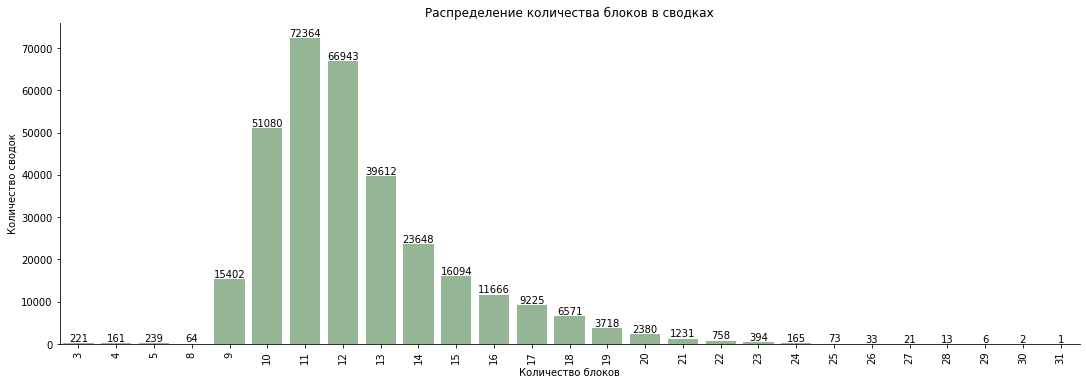

In [7]:
my_barplot( pd.Series(map(lambda x: len(x.split(' ')),meteo['metar'])).value_counts(), 
           'Распределение количества блоков в сводках',
           'Количество блоков',
           'Количество сводок')

стандартная сводка содержит 10 блоков. 

0. Дата и время наблюдения в формате YYYYmmddHHMM
1.  METAR - наименование телеграммы
2. Индекс метеорологического органа выпускающего сводку
3. День и время наблюдения
4. Направление и скорость ветра
5. Видимость
6. Облачность
7. Температура и точка росы
8. Атмосферное давление
9. Другая значимая информация (например, осадки, грозы)

Есть сводки с 9 и 8 блоками, это либо сводки, выпущенные до 2006 года, когда не был внедрен международный стандарт и в них отсутствовали блоки облачности, температуры и точки росы и др., либо сводки с "Хорошей погодой" - CAVOK, когда часть блоков опускается. Так же есть сводки с большим количеством блоков. Это зависит от количества погодных явлений (их может быть 2) или наличия прогноза на посадку, который включается в сводку metar в конце кода. В таком случае количество блоков может доходить до 31. 

Проверим телеграммы, состоящие из менее чем 8 блоков


In [8]:
nill = meteo[pd.Series(map(lambda x: len(x.split(' ')),meteo['metar'].tolist()))<8]
nill.head(5)

,metar
11703,202305291600 METAR ULLI 291600Z NIL=
28963,202206032300 METAR ULLI 032300Z NIL=
75212,201910140400 METAR ULLI NIL=
86881,201902122300 METAR ULLI NIL=
87144,201902071130 METAR ULLI 071130Z NIL=


Это телеграммы об отсутствии сводки metar, они не понадобятся нам для анализа, поэтому мы их удалим и создадим новый датафрейм meteo_new 

In [9]:
(nill.shape[0]*100/meteo.shape[0])
meteo_new = meteo.drop(index = nill.index).reset_index(drop = True)
meteo_new.head(10)

,metar
0,202404281130 METAR ULLI 281130Z 30005MPS CAVOK 11/04 Q1025 R88/090060 NOSIG=
1,202404281100 METAR ULLI 281100Z 30006MPS CAVOK 11/05 Q1025 R88/090060 NOSIG=
2,202404281030 METAR ULLI 281030Z 30005MPS CAVOK 12/06 Q1025 R88/090060 NOSIG=
3,202404281000 METAR ULLI 281000Z 31006MPS CAVOK 13/07 Q1025 R88/090060 NOSIG=
4,202404280930 METAR ULLI 280930Z 32005MPS CAVOK 14/05 Q1024 R28R/090060 NOSIG=
5,202404280900 METAR ULLI 280900Z 22006MPS 190V250 CAVOK 18/04 Q1024 R28R/090060 NOSIG=
6,202404280830 METAR ULLI 280830Z 22005MPS 190V250 CAVOK 18/04 Q1024 R28R/090060 NOSIG=
7,202404280800 METAR ULLI 280800Z 23005MPS 190V250 CAVOK 17/04 Q1024 R28R/090060 NOSIG=
8,202404280730 METAR ULLI 280730Z 23005MPS CAVOK 15/04 Q1024 R28R/090060 NOSIG=
9,202404280700 METAR ULLI 280700Z 23004MPS CAVOK 15/03 Q1024 R88/090060 NOSIG=


In [10]:
meteo_new.query('metar.isna()')

,metar


Документ сформирован правильно, пропусков нет. 

**Дата и время наблюдения**

Создадим столбец с датой

In [11]:
meteo_new['date'] = pd.Series(map(lambda x: x.split(' ')[0],meteo_new['metar'].tolist()))
meteo_new['date'] = pd.Series(map(lambda x:datetime.datetime.strptime(x, '%Y%m%d%H%M'),meteo_new['date'].tolist()))
meteo_new.head()

,metar,date
0,202404281130 METAR ULLI 281130Z 30005MPS CAVOK 11/04 Q1025 R88/090060 NOSIG=,2024-04-28 11:30:00
1,202404281100 METAR ULLI 281100Z 30006MPS CAVOK 11/05 Q1025 R88/090060 NOSIG=,2024-04-28 11:00:00
2,202404281030 METAR ULLI 281030Z 30005MPS CAVOK 12/06 Q1025 R88/090060 NOSIG=,2024-04-28 10:30:00
3,202404281000 METAR ULLI 281000Z 31006MPS CAVOK 13/07 Q1025 R88/090060 NOSIG=,2024-04-28 10:00:00
4,202404280930 METAR ULLI 280930Z 32005MPS CAVOK 14/05 Q1024 R28R/090060 NOSIG=,2024-04-28 09:30:00


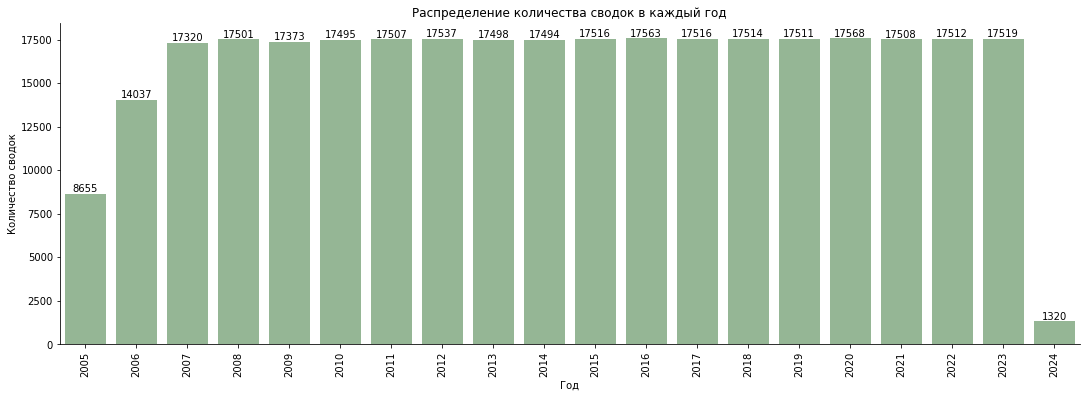

In [12]:
my_barplot(  meteo_new['date'].dt.year.value_counts(), 
           'Распределение количества сводок в каждый год',
           'Год',
           'Количество сводок')


Видим, что до 2007 года сводок было меньше. Это связано с тем, что до 2007 аэродром работал не круглосуточно, а с 2007 года Обществом создана и внедрена система управления качеством соответствующая международному стандарту ИСО 9001, необходимая для осуществления общего руководства качеством метеорологической информации, предоставляемой эксплуатантам воздушных судов и сводки стали выпускаться круглосуточно.

Добавим другие столбцы.

In [13]:
meteo_new['time'] = meteo_new['date'].dt.time
meteo_new['day'] = meteo_new['date'].dt.date
meteo_new['month'] = meteo_new['date'].dt.month
meteo_new['season'] = meteo_new['date'].dt.quarter

In [14]:
ses = []
for d in meteo_new['month'].tolist():
  if (d == 1 or d == 2 or d ==12):
    ses.append('winter')
  elif (d==3 or d==4 or d ==5):
    ses.append('spring')
  elif (d==6 or d==7 or d ==8):
    ses.append('summer')
  else:
    ses.append('autumn')
#Проверка
meteo_new['season'] = pd.Series(ses)
meteo_new.pivot_table(index = 'season', values = 'day', aggfunc = ['min','max'])

,min,max
,day,day
season,,
autumn,2005-09-01,2023-11-30
spring,2005-03-01,2024-04-28
summer,2005-06-01,2023-08-31
winter,2005-01-01,2023-12-31


In [15]:
# Определяем функцию для определения времени суток
def determine_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Утро'
    elif 12 <= hour < 18:
        return 'День'
    elif 18 <= hour < 24:
        return 'Вечер'
    else:
        return 'Ночь'

# Применяем лямбда-функцию с использованием map для создания столбца time_of_day
meteo_new['time_of_day'] = pd.Series(map(lambda x: determine_time_of_day(x.hour), meteo_new['date']))


# Проверим правильность разделения на категории
tod = ['Утро','День','Вечер','Ночь']

for d in tod:
    print(d,':',
          'от',
         meteo_new.query('time_of_day == @d')['date'].dt.hour.min(),
          'до',
          meteo_new.query('time_of_day == @d')['date'].dt.hour.max())

Утро : от 6 до 11
День : от 12 до 17
Вечер : от 18 до 23
Ночь : от 0 до 5


##### **Направление и скорость ветра**

* dddffGfmfm[MPS или KT] направление, скорость и порывы ветра
* dndndnVdxdxdx - резкое изменение направления скорости ветра

Группу с изменением направления ветра дешифрировать не будем ввиду сложности интерпретации результатов.

In [16]:
wind_list = []
metar_list = pd.Series(map(lambda x: x.split(' '),meteo_new['metar'].tolist()))
for p in range(len(metar_list)):
  for j in metar_list[p]:
    if j.__contains__('MPS') or j.__contains__('KT'):
      wind_list.append(j)
      break
    else:
      continue

# meteo_new['wind'] = pd.Series(wind_list)
meteo_new['direction'] = pd.Series(map(lambda x: x[0:3],wind_list))
meteo_new['speed'] = pd.Series(map(lambda x: x[4:5],wind_list))

gust_series = []
for g in wind_list:
  if g.__contains__('G'):
    gust_series.append(g[6:8])
  else:
    gust_series.append(0)
meteo_new['gust'] = pd.Series(gust_series)

In [17]:
def convert_to_int(x):
    try:
        return int(x)
    except ValueError:
        return None
meteo_new['direction'] = pd.Series(map(convert_to_int, meteo_new['direction'].tolist())).replace(0,np.nan)
meteo_new['speed'] = pd.Series(map(convert_to_int, meteo_new['speed'].tolist()))
meteo_new['gust'] = pd.Series(map(convert_to_int, meteo_new['gust'].tolist()))

Проверим правильно ли дешифруется metar с помощью 10 случайных строк.

In [18]:
def examination(data,par):
  par2 = ['metar']
  for i in par:
    par2.append(i)
  # Выбираем 10 случайных строк
  random_rows = np.random.choice(data.index, 10)
  # Выводим случайные строки в виде датафрейма
  display(data.loc[random_rows,par2])

In [19]:
examination(meteo_new,['direction','speed','gust'])

,metar,direction,speed,gust
252301,200909021500 METAR ULLI 021500Z 18005MPS 150V210 CAVOK 21/11 Q1017 NOSIG=,180.0,5.0,0
182726,201308250030 METAR ULLI 250030Z 00000MPS 6000 NSC 07/05 Q1022 NOSIG=,NaN,0.0,0
24103,202209130730 METAR ULLI 130730Z 14003MPS 110V170 CAVOK 12/08 Q1014 R10L/090060 NOSIG=,140.0,3.0,0
110025,201710181200 METAR ULLI 181200Z 30008MPS 8000 -SHRA SCT008 BKN022CB OVC036 07/05 Q1000 R88/290050 TEMPO 30009G15MPS=,300.0,8.0,0
309837,200510061200 METAR ULLI 061200Z 26004MPS 9999 OVC030 13/09 Q1027 NOSIG RMK 28090072 78//=,260.0,4.0,0
282960,200710311100 METAR ULLI 311100Z 17005MPS 7000 -RA BKN021 OVC066 05/04 Q1014 10290052 NOSIG RMK MOD TURB IAO 0M-600 10L/17005G08MPS=,170.0,5.0,0
243580,201003041400 METAR ULLI 041400Z 29001MPS 8000 -SN BKN025 OVC066 M03/M05 Q1003 60490340 10520345 NOSIG=,290.0,1.0,0
208769,201202281130 METAR ULLI 281130Z 16005MPS 9999 BKN018 OVC200 M05/M08 Q1007 88610550 NOSIG=,160.0,5.0,0
64242,202005291600 METAR ULLI 291600Z 33005MPS CAVOK 16/01 Q1022 R28R/090060 NOSIG=,330.0,5.0,0
105807,201801141000 METAR ULLI 141000Z 21002MPS 6000 SCT011 OVC018 M05/M06 Q1041 R28L/620350 R28R/310150 NOSIG=,210.0,2.0,0


Проверим наличие пропусков в значении скорости ветра 

In [20]:
meteo_new.query('speed.isna()')

,metar,date,time,day,month,season,time_of_day,direction,speed,gust
277856,200803160330 METAR ULLI 160330Z /////MPS 2400 -SN BR SCT006 OVC020 M01/M01 Q0998 28590535 78590340 NOSIG=,2008-03-16 03:30:00,03:30:00,2008-03-16,3,spring,Ночь,NaN,NaN,0
278517,200803020630 METAR ULLI 020630Z /////MPS 6000 -SN OVC016 M01/M03 Q0979 88190062 NOSIG=,2008-03-02 06:30:00,06:30:00,2008-03-02,3,spring,Утро,NaN,NaN,0
280485,200801210430 METAR ULLI 210430Z /////MPS 7000 -SHRASN OVC024CB 01/01 Q0997 88290052 NOSIG=,2008-01-21 04:30:00,04:30:00,2008-01-21,1,winter,Ночь,NaN,NaN,0
286448,200708191200 METAR ULLI 191200Z /////MPS 9999 BKN033 BKN066 21/10 Q1019 NOSIG=,2007-08-19 12:00:00,12:00:00,2007-08-19,8,summer,День,NaN,NaN,0
304831,200605260800 METAR ULLI 260800Z P49MPS 9999 SCT040 BKN200 14/06 Q1008 NOSIG=,2006-05-26 08:00:00,08:00:00,2006-05-26,5,spring,Утро,NaN,NaN,0
304964,200605231300 METAR ULLI 231300Z P49MPS CAVOK 18/11 Q1007 NOSIG=,2006-05-23 13:00:00,13:00:00,2006-05-23,5,spring,День,NaN,NaN,0
305704,200603271200 METAR ULLI 271200Z /////MPS CAVOK 01/M09 Q1018 28090070 NOSIG=,2006-03-27 12:00:00,12:00:00,2006-03-27,3,spring,День,NaN,NaN,0


Есть сводки, где в сводке по неизвестным причинам не указаны параметры ветра. Таких сводок всего 7, поэтому они не повлияют на дальнейший анализ - удалим данные сводки.

In [21]:
meteo_new = meteo_new.dropna (subset=['speed'])
meteo_new.query('speed.isna()')

,metar,date,time,day,month,season,time_of_day,direction,speed,gust


Пропуски в значениях направления ветра

In [22]:
meteo_new.query('direction.isna()').head(10)

,metar,date,time,day,month,season,time_of_day,direction,speed,gust
35,202404271800 METAR ULLI 271800Z 00000MPS CAVOK 10/M00 Q1021 R28L/090060 NOSIG=,2024-04-27 18:00:00,18:00:00,2024-04-27,4,spring,Вечер,NaN,0.0,0
36,202404271730 METAR ULLI 271730Z VRB01MPS CAVOK 11/M01 Q1021 R28L/090060 NOSIG=,2024-04-27 17:30:00,17:30:00,2024-04-27,4,spring,День,NaN,1.0,0
37,202404271700 METAR ULLI 271700Z VRB01MPS CAVOK 12/M01 Q1021 R28L/090060 NOSIG=,2024-04-27 17:00:00,17:00:00,2024-04-27,4,spring,День,NaN,1.0,0
54,202404270830 METAR ULLI 270830Z VRB01MPS 9999 BKN032 13/04 Q1018 R28R/090060 NOSIG=,2024-04-27 08:30:00,08:30:00,2024-04-27,4,spring,Утро,NaN,1.0,0
55,202404270800 METAR ULLI 270800Z VRB01MPS 9999 SCT032 11/04 Q1018 R28R/090060 NOSIG=,2024-04-27 08:00:00,08:00:00,2024-04-27,4,spring,Утро,NaN,1.0,0
62,202404270430 METAR ULLI 270430Z VRB01MPS CAVOK 05/04 Q1017 R88/090060 NOSIG=,2024-04-27 04:30:00,04:30:00,2024-04-27,4,spring,Ночь,NaN,1.0,0
65,202404270300 METAR ULLI 270300Z 00000MPS CAVOK 02/01 Q1016 R10R/090060 NOSIG=,2024-04-27 03:00:00,03:00:00,2024-04-27,4,spring,Ночь,NaN,0.0,0
68,202404270130 METAR ULLI 270130Z VRB01MPS 8000 NSC 01/00 Q1016 R10R/090060 NOSIG=,2024-04-27 01:30:00,01:30:00,2024-04-27,4,spring,Ночь,NaN,1.0,0
69,202404270100 METAR ULLI 270100Z 00000MPS 9000 NSC 01/M00 Q1015 R10R/090060 NOSIG=,2024-04-27 01:00:00,01:00:00,2024-04-27,4,spring,Ночь,NaN,0.0,0
70,202404270030 METAR ULLI 270030Z VRB01MPS 9000 NSC 01/M00 Q1015 R10R/090060 NOSIG=,2024-04-27 00:30:00,00:30:00,2024-04-27,4,spring,Ночь,NaN,1.0,0


Пропуски встречаются в основном в сводках с "Хорошей погодой" так как ветра просто нет, либо где направление ветра неустойчивое VRB

In [23]:
meteo_new.query('gust.isna()').head(10)

,metar,date,time,day,month,season,time_of_day,direction,speed,gust


Пропуски в столбце с порывами ветра отсутствуют, так как при создании столбца автоматически заменены на 0 - без порывов

Посмотрим распределение направления, скорости и порывов ветра. 

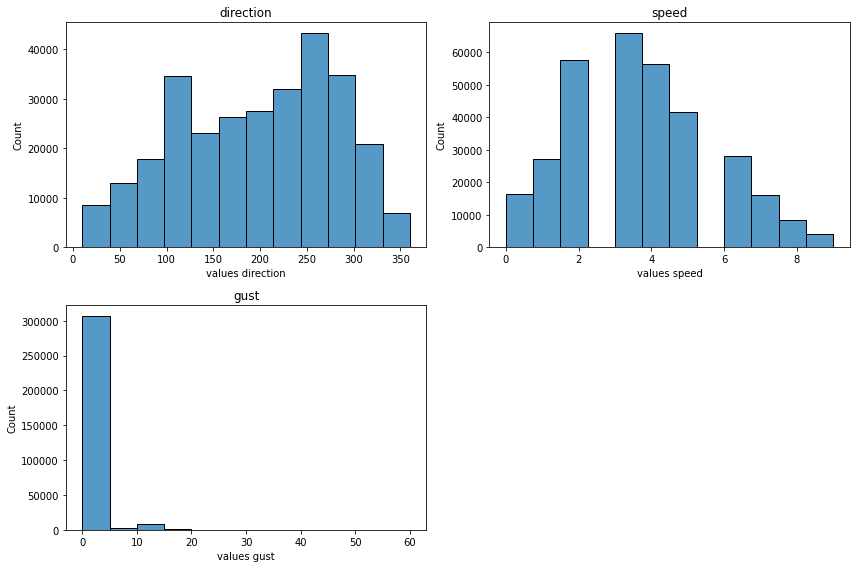

In [24]:
list_wind = ['direction','speed','gust']
fig = plt.figure(figsize=(12, 8))
for i in range(0,len(list_wind)):
    plt.subplot(2, 2, i+1)
    sns.histplot(data= meteo_new[list_wind[i]],bins = 12)
    plt.title(list_wind[i])
    plt.xlabel(f'values {list_wind[i]}')
plt.tight_layout()
plt.show()

* Направление ветра

По распределению видно, что направление ветра принимает разные значения, но чаще всего 100° и 250°, то есть чаще всего на аэродроме дуют ветра юго-восточного и юго-западного направлений

* Скорость ветра

Чаще всего встречается скорость ветра от 2 до 4 м/с, максимальное значение скорости ветра 9 м/С

* Порывы

Наиболее часто порывы ветра от 0 до 5 м/с. Есть сводки с сильным порывистым ветром до 20м/с. Так же видим, что есть порывы более 30 м/с, это похоже на ошибку в записи сводки


In [25]:
meteo_new[meteo_new['gust']>30]

,metar,date,time,day,month,season,time_of_day,direction,speed,gust
315548,200502061300 METAR ULLI 061300Z 26003G60MPS 1900 BR -SHSN BKN008 OVC017CB M03/M05 Q1036 TEMPO 1000 RMK 650089 650981 88450345=,2005-02-06 13:00:00,13:00:00,2005-02-06,2,winter,День,260.0,3.0,60


Да, действительно, скорость ветра 3 м/с и порыв 60 - это невозможно. Удалим эту сводку из данных. 

In [26]:
meteo_new = meteo_new.drop(index = meteo_new[meteo_new['gust']>30].index,axis=0).reset_index(drop = True)
meteo_new[meteo_new['gust']>30]

,metar,date,time,day,month,season,time_of_day,direction,speed,gust


#####  **Видимость**

Видимость в metar записывается в виде:

* VVVV  - преобладающая видимость (в случае видимости более 10км записывается 9999)
* VnVnVnVnDV - минимальная видимость
* CAVOK - в случае видимости более 10км и прочих критериях для записи хорошей погоды. 

В данном случае нас интересует преобладающая видимость, поэтому минимальную видимость (VnVnVnVnDV) мы не будем рассматривать. При CAVOK и 9999 мы оставим пропуски, так как хотя видимость в этом случае превышает 10 километров, точное ее значение неизвестно.


In [27]:
vis_list = []
# metar_list = pd.Series(map(lambda x: x.split(' '),meteo_new['metar'].tolist()))
for p in meteo_new['metar'].tolist():
  ma = re.search(' \d{4} ', p)
  try:
    vis_list.append(ma[0][1:5])
  except:
    vis_list.append(np.nan)
meteo_new['visibility'] = pd.Series(vis_list).replace({"9999":"np.nan"})

In [28]:
meteo_new['visibility'] = pd.Series(map(convert_to_int, meteo_new['visibility'].tolist()))

Проверим правильность дешифровки

In [29]:
examination(meteo_new,['visibility'])

,metar,visibility
124174,201612271630 METAR ULLI 271630Z 28006MPS 7000 -SN SCT007 BKN026 01/M01 Q0997 R28L/520345 R28R/290050 NOSIG=,7000.0
171158,201404230430 METAR ULLI 230430Z 01006MPS CAVOK 06/M06 Q1023 88090070 NOSIG=,NaN
172726,201403211230 METAR ULLI 211230Z 22010G15MPS 190V250 9999 BKN046 OVC066 11/03 Q0990 88190060 NOSIG RMK 28L/23006G11MPS 28R/22010G15MPS=,NaN
198851,201209220700 METAR ULLI 220700Z 12003MPS CAVOK 11/09 Q1021 TEMPO 2000 BR=,2000.0
238980,201006081330 METAR ULLI 081330Z 05006MPS 020V080 9999 OVC013 10/08 Q1009 NOSIG RMK MOD ICE INC 3000-5000=,NaN
124025,201612301900 METAR ULLI 301900Z 26007MPS 230V290 9999 OVC012 04/02 Q1009 WS ALL RWY R88/290050 NOSIG=,NaN
40281,202110110200 METAR ULLI 110200Z 20002MPS 140V270 CAVOK 09/04 Q1021 R28L/090060 NOSIG=,NaN
67298,202003270000 METAR ULLI 270000Z 26003MPS CAVOK 01/M03 Q1032 R28L/090060 NOSIG=,NaN
60674,202008120000 METAR ULLI 120000Z 33002MPS CAVOK 11/07 Q1021 R10R/090060 NOSIG=,NaN
76634,201909141100 METAR ULLI 141100Z 31009G14MPS 9999 SCT033 14/04 Q1012 R88/090060 NOSIG=,NaN


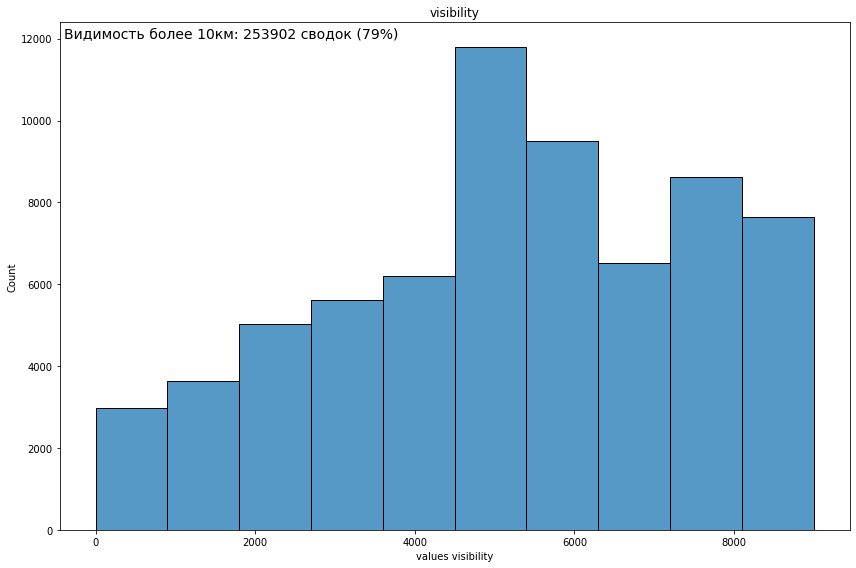

In [30]:
isna = meteo_new['visibility'].isna().sum()
alls =  meteo_new.shape[0]

fig = plt.figure(figsize=(12, 8))
sns.histplot(data= meteo_new['visibility'],bins = 10)
plt.title('visibility')
plt.xlabel('values visibility')
plt.tight_layout()
plt.text(-400, 12000, f'Видимость более 10км: {isna} сводок ({round(isna*100/alls)}%)',fontsize=14)
plt.tight_layout()
plt.show()

* Чаще всего встречается значения видимости около 5000 и 6000 км
* При этом если рассмотреть значения Nan (когда видимость была больше 10км), то таких значений в наборе данных более 25 000 (79% всех сводок)

##### **Облачность**

Облачность в metar кодируемся как:

* NsNsNshshshs - Количество облаков: FEW/SCT/BKN/OVC, и высота нижней границы слоя (массива) облаков hshshs сообщается в величинах, кратных 30 м
* VVhshshs - вертикальная видимость. Если состояние неба не определяется, например, не видно из-за тумана и/или других явлений, вместо группы NsNsNshshshs передается группа VVhshshs
* NSC - нет значимой для полетов облачности
* NCD нет облачности; используется, когда автоматическая система не обнаружила облаков

Количество групп облачности, как правило, не превышает трех.  В тех случаях, когда наблюдается несколько слоев облаков или отдельных массивов облаков, количество и высота нижней границы облаков указывается в порядке возрастания высоты нижней границы облаков. Мы будем рассматривать первое значение - наиболее низкую облачность. 

Создание столбца со всеми группами облачности cloud и столбца с НГО cloud_base

In [31]:
metars_for_cld = list(map(lambda x:re.split('Q\d{4}', re.split('\d{6}Z', x ,maxsplit=0)[1],maxsplit=0)[0].split(' ') ,meteo_new['metar'].tolist()))
alls_cld = ['FEW','SCT','BKN','OVC']
cloud_list = []
for met in metars_for_cld:
  phen_met = []
  for i in met:
    for j in alls_cld:
      if i.__contains__(j):
        if i.__contains__('='):
          i=i[:-1]
        phen_met.append(i)
  cloud_list.append(phen_met)
meteo_new['cloud'] = pd.Series(map(lambda x: ', '.join(list(set(x))),cloud_list))


In [32]:
vngo = []

for i in meteo_new['cloud'].tolist():
    cld = []
    col = list(map(lambda x: cld.append(int(x)),re.findall('\d{3}', i)))
    try:
        vngo.append(min(cld)*30)
    except:
        vngo.append('')
meteo_new['cloud_base'] = pd.Series(vngo).replace('',np.nan)

Создание столбца с вертикальной видимостью.

In [33]:
metars_for_vv = metars_for_cld 
vv_list = []
for met in metars_for_vv:
    vv_met = []
    for i in met:
        if i.__contains__('VV'):
            vv_met.append(i)
    vv_list.append(vv_met)
    
meteo_new['vertical_visibility'] = pd.Series([int(y.split('VV')[1].split('CB')[0])*30 for y in x] for x in vv_list)

In [34]:
vv = []
for i in meteo_new['vertical_visibility'].tolist():
    try:
        vv.append(i[0])
    except:
        vv.append(np.nan)
        

meteo_new['vertical_visibility'] = pd.Series(vv)

Высота нижней границы облачности вместе с вертикальной видимостью 

In [35]:
meteo_new['cloud_base'] = meteo_new['cloud_base'].fillna(meteo_new['vertical_visibility'])

In [36]:
examination(meteo_new,['cloud','cloud_base','vertical_visibility'])

,metar,cloud,cloud_base,vertical_visibility
246256,201001071630 METAR ULLI 071630Z 10005MPS 2200 -SN BLSN BKN015 OVC030 M08/M09 Q1008 88452042 TEMPO 0400 +SN=,"BKN015, OVC030",450.0,NaN
24546,202209040200 METAR ULLI 040200Z 28003MPS 9999 SCT019 05/03 Q1021 R28R/090060 NOSIG=,SCT019,570.0,NaN
173196,201403111700 METAR ULLI 111700Z 27005MPS CAVOK 02/M02 Q1023 28////// 78090070 NOSIG=,,NaN,NaN
62358,202007072200 METAR ULLI 072200Z 26002MPS 220V280 9999 SCT031 15/12 Q1007 R28L/090060 NOSIG=,SCT031,930.0,NaN
19376,202212201900 METAR ULLI 201900Z 14003MPS 110V180 9000 -SN BKN043 M10/M14 Q1011 R10R/510550 NOSIG=,BKN043,1290.0,NaN
278249,200803072030 METAR ULLI 072030Z 31004G09MPS 270V360 9999 OVC033 M01/M04 Q1005 88190060 NOSIG=,OVC033,990.0,NaN
130608,201608151330 METAR ULLI 151330Z 27006MPS 240V300 9999 SCT017CB BKN028 17/13 Q1007 R88/090060 NOSIG=,"SCT017CB, BKN028",510.0,NaN
224429,201104072330 METAR ULLI 072330Z 07006MPS 9000 -RA BKN006 OVC020 03/02 Q0983 60290052 10////// TEMPO 1600 SHRA BKN002 RMK OBST OBSC=,"OVC020, BKN006",180.0,NaN
90692,201811251030 METAR ULLI 251030Z 26003MPS 220V290 9999 -SHSN SCT017CB BKN033 01/M01 Q1011 R88/290050 NOSIG=,"SCT017CB, BKN033",510.0,NaN
204313,201205310930 METAR ULLI 310930Z 30005MPS 250V360 9999 BKN046 BKN066 13/M01 Q1008 NOSIG=,"BKN046, BKN066",1380.0,NaN


Посмотрим распределение НГО

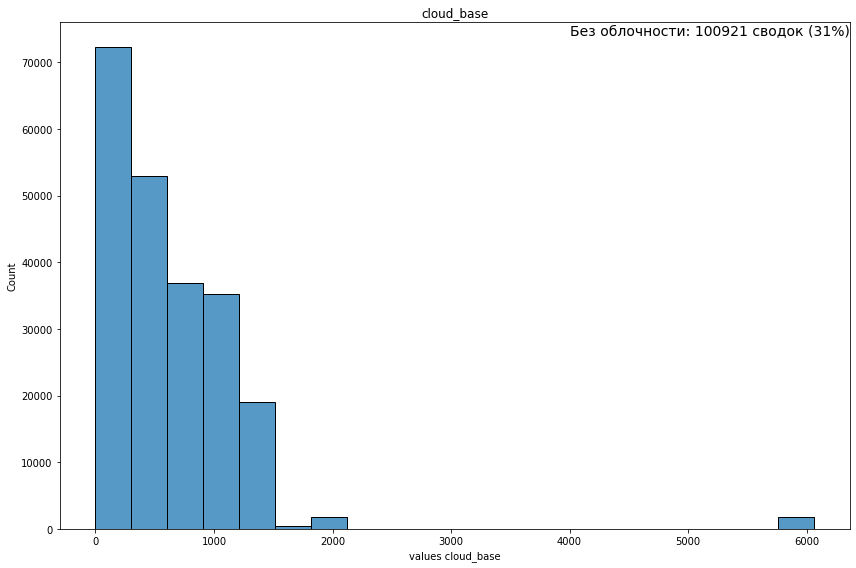

In [37]:
isna = meteo_new['cloud_base'].isna().sum()
alls =  meteo_new.shape[0]

fig = plt.figure(figsize=(12, 8))
sns.histplot(data= meteo_new['cloud_base'],bins = 20)
plt.title('cloud_base')
plt.xlabel('values cloud_base')
plt.tight_layout()
plt.text(4000, 74000, f'Без облочности: {isna} сводок ({round(isna*100/alls)}%)',fontsize=14)
plt.tight_layout()
plt.show()

* Часто наблюдается облачность с НГО менее 500м. Такая облачность считается опасной для авиации и при этом есть сложности с прогнозированием такой низкой облачности. 
* Сводок, в которых не отмечалось облачности всего 31% от всех наблюдений. 

##### **Атмосферное давление**
В сводках metar указывается давление QNH - давление  в целых гектопаскалях (гПа), приведенное к уровню моря по
стандартной атмосфере.

* QPHPHPHPH - Q буквенный указатель группы,  PHPHPHPH значение давления 



In [38]:
qnh_list = []
for p in meteo_new['metar'].tolist():
  ma = re.search(' Q\d{4} ', p) or re.search(' Q\d{4}=', p)
  try:
    qnh_list.append(ma[0][2:6])
  except:
    qnh_list.append(np.nan)
meteo_new['pressure'] = pd.Series(qnh_list)
meteo_new['pressure'] = pd.Series(map(convert_to_int, meteo_new['pressure'].tolist()))

Проверим правильность дешифровки 

In [39]:
examination(meteo_new,['pressure'])

,metar,pressure
171458,201404162230 METAR ULLI 162230Z 28002MPS 260V320 CAVOK 00/M05 Q1022 28////// 78090070 NOSIG=,1022.0
65469,202005040230 METAR ULLI 040230Z 17001MPS 9000 MIFG NSC 04/04 Q1011 R28L/090060 NOSIG=,1011.0
247090,200912210100 METAR ULLI 210100Z 09003MPS CAVOK M12/M14 Q1007 10411041 NOSIG=,1007.0
130827,201608110000 METAR ULLI 110000Z 00000MPS 6000 -SHRA SCT030CB 14/12 Q1012 R10R/290050 NOSIG=,1012.0
188354,201304291500 METAR ULLI 291500Z 19006MPS 170V240 CAVOK 12/M02 Q1017 60////// 10090070 NOSIG=,1017.0
205224,201205120830 METAR ULLI 120830Z 26012G18MPS 9999 SCT030 BKN066 16/04 Q1000 NOSIG=,1000.0
273794,200806090330 METAR ULLI 090330Z 20002MPS 160V230 9999 -SHRA SCT046CB OVC066 13/13 Q1004 NOSIG=,1004.0
91339,201811112200 METAR ULLI 112200Z 15005MPS 110V190 9999 SCT019CB OVC030 03/M01 Q1032 R10R/290050 NOSIG=,1032.0
228313,201101170030 METAR ULLI 170030Z 13006MPS CAVOK M12/M14 Q1021 60////// 10420545 NOSIG=,1021.0
290344,200705300000 METAR ULLI 300000Z 03003MPS 010V100 9999 OVC004 14/12 Q1009 NOSIG RMK QBB140 MS OBSC=,1009.0


In [40]:
display(meteo_new.query('pressure.isna()'), meteo_new['pressure'].isna().sum())

,metar,date,time,day,month,season,time_of_day,direction,speed,gust,visibility,cloud,cloud_base,vertical_visibility,pressure
106118,201801072230 METAR ULLI 072230Z 27007MPS 1700 1200SE R28L/P2000N R28R/P2000U SHSN=,2018-01-07 22:30:00,22:30:00,2018-01-07,1,winter,Вечер,270.0,7.0,0,1700.0,,NaN,NaN,NaN
120574,201703121700 METAR ULLI 121700Z 28002MPS 240V320 0150 0100NE R28L/0550N R28R/0500N=,2017-03-12 17:00:00,17:00:00,2017-03-12,3,spring,День,280.0,2.0,0,150.0,,NaN,NaN,NaN
122662,201701280500 METAR ULLI 280500Z 24003MPS 210V280 0700 0600NW R28L/1900 R28R/1400=,2017-01-28 05:00:00,05:00:00,2017-01-28,1,winter,Ночь,240.0,3.0,0,700.0,,NaN,NaN,NaN
138688,201602290500 METAR ULLI 290500Z 26002MPS 230V290 0900 0100NW R28L/P2000 R28R/0900=,2016-02-29 05:00:00,05:00:00,2016-02-29,2,winter,Ночь,260.0,2.0,0,900.0,,NaN,NaN,NaN
139913,201602031630 METAR ULLI 031630Z 01002MPS 320V040 1000 0900NE R28L/P2000 R28R/P2000=,2016-02-03 16:30:00,16:30:00,2016-02-03,2,winter,День,10.0,2.0,0,1000.0,,NaN,NaN,NaN
144222,201511052130 METAR ULLI 052130Z 25002MPS 190V300 0200 0100E R28L/P2000U R28R/0350N=,2015-11-05 21:30:00,21:30:00,2015-11-05,11,autumn,Вечер,250.0,2.0,0,200.0,,NaN,NaN,NaN
155126,201503231600 METAR ULLI 231600Z 20003G09MPS 1300 R28L/1200VP2000D R28R/1100VP2000D=,2015-03-23 16:00:00,16:00:00,2015-03-23,3,spring,День,200.0,3.0,9,1300.0,,NaN,NaN,NaN
159407,201412241100 METAR ULLI 241100Z 28002MPS 270V340 0150 R10R/0250VP2000D R10L/0150N=,2014-12-24 11:00:00,11:00:00,2014-12-24,12,winter,Утро,280.0,2.0,0,150.0,,NaN,NaN,NaN
161086,201411191000 METAR ULLI 191000Z 12002MPS 080V160 0350 R10R/0300V0700U R10L/0350N=,2014-11-19 10:00:00,10:00:00,2014-11-19,11,autumn,Утро,120.0,2.0,0,350.0,,NaN,NaN,NaN
179930,201310220700 METAR ULLI 220700Z 17002MPS 130V210 0450 R10R/0600N R10L/0500VP2000D=,2013-10-22 07:00:00,07:00:00,2013-10-22,10,autumn,Утро,170.0,2.0,0,450.0,,NaN,NaN,NaN


24

В некоторых сводках давление не указывалось. Таких сводок всего 24, дальнейшему анализу отсутствующие значения не помешают, удалять их не будем.

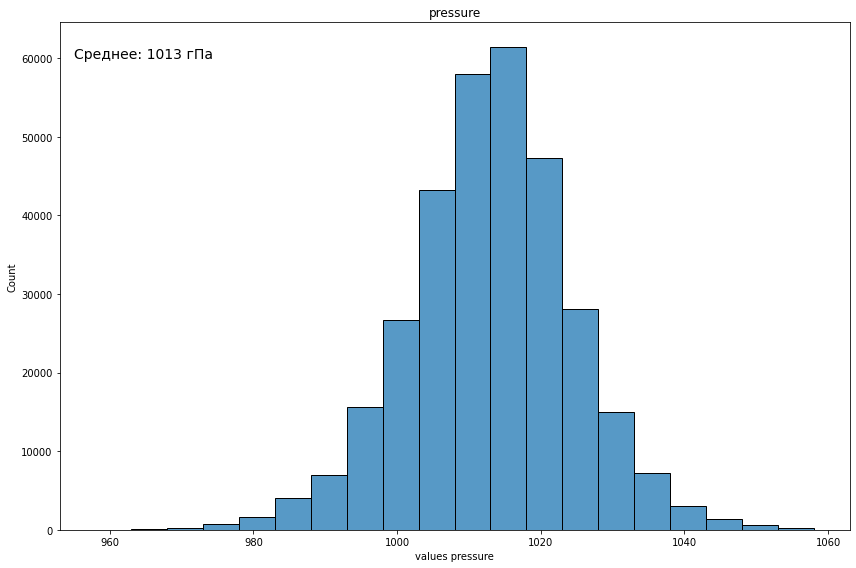

In [41]:
mean = round(meteo_new['pressure'].mean())

fig = plt.figure(figsize=(12, 8))
sns.histplot(data= meteo_new['pressure'],bins = 20)
plt.title('pressure')
plt.xlabel('values pressure')
plt.tight_layout()
plt.tight_layout()
plt.text(955, 60000, f'Среднее: {mean} гПа',fontsize=14)
plt.show()

Распределение давления QNH по форме похоже на нормальное распределение. Чаще всего наблюдается значение давления около 1013 гПа - около среднего.

#####  **Температура и точка росы**

T´T´/Td´Td´

* T´T´ - температура воздуха
* Td´T´d - температура точки росы


In [42]:
def convert_to_int(temp_str):
    ###Преобразует строку температуры в целое число с учетом знака.
    if temp_str.startswith('M'):
        return -int(temp_str[1:])
    else:
        return int(temp_str)

temp_list = []
dew_list = []
pattern = r'(?<!R)(M?\d\d)/(M?\d\d)'

for metar in meteo_new['metar']:
    match = re.search(pattern, metar)
    if match:
        temp, dew = match.groups()
        temp_list.append(convert_to_int(temp))
        dew_list.append(convert_to_int(dew))
    else:
        temp_list.append(np.nan)
        dew_list.append(np.nan)

meteo_new['temperature'] = pd.Series(temp_list)
meteo_new['dew_point'] = pd.Series(dew_list)

По значениям давления, температур воздуха и точки росы рассчитаем относительную влажность воздуха.

In [43]:
# Значения констант
alpha = 6.112
beta = 17.67
gamma = 243.5

# Список для хранения значений влажности
humidity_list = []

# Вычисляем влажность для каждой строки в датафрейме meteo_new
for i in range(len(meteo_new)):
    T = meteo_new['temperature'][i]
    Tp = meteo_new['dew_point'][i]
    P = meteo_new['pressure'][i]

    saturation_vapor_pressure = alpha * math.exp((beta * T) / (gamma + T))
    actual_vapor_pressure = alpha * math.exp((beta * Tp) / (gamma + Tp))
    humidity = 100 * (actual_vapor_pressure / saturation_vapor_pressure) * math.exp(
        (17.625 * (T - Tp)) / (243.04 + (T + Tp) / 2) * (P / 1013.25 - 1)
    )
    humidity_list.append(humidity)

# Добавляем столбец с вычисленной влажностью в датафрейм meteo_new
meteo_new['humidity'] = pd.Series(humidity_list)




Проверка

In [44]:
examination(meteo_new,['temperature','dew_point','humidity'])

,metar,temperature,dew_point,humidity
260034,200903240400 METAR ULLI 240400Z 11002MPS 6000 -SN OVC026 M05/M05 Q0992 10490540 NOSIG=,-5.0,-5.0,100.000000
298204,200612132300 METAR ULLI 132300Z 20007MPS 9999 BKN009 OVC026 03/02 Q1005 28290052 NOSIG=,3.0,2.0,93.082496
167671,201407050130 METAR ULLI 050130Z 25002MPS 220V330 CAVOK 11/09 Q1014 NOSIG=,11.0,9.0,87.475808
300604,200609231030 METAR ULLI 231030Z 26004MPS 7000 OVC200 20/14 Q1023 NOSIG=,20.0,14.0,68.621501
246674,200912291900 METAR ULLI 291900Z 03004G09MPS 010V100 9999 SCT014 OVC066 M09/M12 Q0999 60////// 10290052 NOSIG=,-9.0,-12.0,78.586441
254941,200907090300 METAR ULLI 090300Z 11005MPS 7000 BKN009 OVC026 17/15 Q1001 NOSIG=,17.0,15.0,87.859145
115592,201706241230 METAR ULLI 241230Z 00000MPS 9999 BKN043 16/06 Q1004 R88/090060 NOSIG=,16.0,6.0,51.125667
278510,200803020930 METAR ULLI 020930Z 06004G09MPS 020V100 9999 OVC016 M00/M03 Q0978 88190062 NOSIG=,0.0,-3.0,79.609927
22716,202210120500 METAR ULLI 120500Z 24005MPS 9999 FEW013 07/05 Q1015 R88/090060 NOSIG=,7.0,5.0,87.110323
103999,201802210200 METAR ULLI 210200Z 25002MPS 9999 FEW011 M19/M21 Q1026 R28L/410548 NOSIG=,-19.0,-21.0,84.342435


In [45]:
meteo_new.query('temperature.isna() or dew_point.isna() or humidity.isna()')[['metar','pressure','temperature','dew_point','humidity']]

,metar,pressure,temperature,dew_point,humidity
106118,201801072230 METAR ULLI 072230Z 27007MPS 1700 1200SE R28L/P2000N R28R/P2000U SHSN=,NaN,NaN,NaN,NaN
120574,201703121700 METAR ULLI 121700Z 28002MPS 240V320 0150 0100NE R28L/0550N R28R/0500N=,NaN,NaN,NaN,NaN
122662,201701280500 METAR ULLI 280500Z 24003MPS 210V280 0700 0600NW R28L/1900 R28R/1400=,NaN,NaN,NaN,NaN
138688,201602290500 METAR ULLI 290500Z 26002MPS 230V290 0900 0100NW R28L/P2000 R28R/0900=,NaN,NaN,NaN,NaN
139913,201602031630 METAR ULLI 031630Z 01002MPS 320V040 1000 0900NE R28L/P2000 R28R/P2000=,NaN,NaN,NaN,NaN
144222,201511052130 METAR ULLI 052130Z 25002MPS 190V300 0200 0100E R28L/P2000U R28R/0350N=,NaN,NaN,NaN,NaN
155126,201503231600 METAR ULLI 231600Z 20003G09MPS 1300 R28L/1200VP2000D R28R/1100VP2000D=,NaN,NaN,NaN,NaN
159407,201412241100 METAR ULLI 241100Z 28002MPS 270V340 0150 R10R/0250VP2000D R10L/0150N=,NaN,NaN,NaN,NaN
161086,201411191000 METAR ULLI 191000Z 12002MPS 080V160 0350 R10R/0300V0700U R10L/0350N=,NaN,NaN,NaN,NaN
179930,201310220700 METAR ULLI 220700Z 17002MPS 130V210 0450 R10R/0600N R10L/0500VP2000D=,NaN,NaN,NaN,NaN


* Пропуски во всех трех столбцах (температуры, точки росы и влажности) возникают в случаях, когда данных о температуре в коде нет.
* Есть случаи, когда есть данные о температуре, но нет информации о давлении, тогда расчёт влажности становится невозможным.
* В одном случае (срок 2006-08-20-20:00) ошибка в записи кода "Q1014TEMPO" давление не прочиталось и влажность не была посчитана.


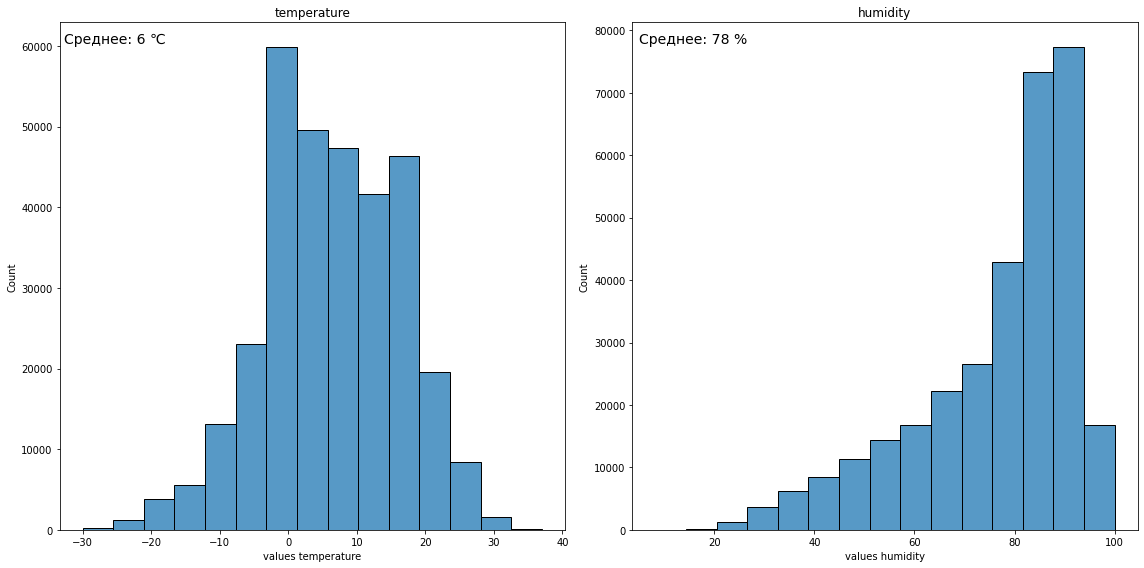

In [46]:
list_temp = ['temperature','humidity']
mean_t = round(meteo_new['temperature'].mean())
mean_h = round(meteo_new['humidity'].mean())
fig = plt.figure(figsize=(16, 8))
for i in range(0,len(list_temp)):
    plt.subplot(1, 2, i+1)
    sns.histplot(data= meteo_new[list_temp[i]],bins = 15)
    plt.title(list_temp[i])
    plt.xlabel(f'values {list_temp[i]}')
plt.tight_layout()
plt.text(-110,78000, f'Среднее: {mean_t} ℃',fontsize=14)
plt.text(5,78000, f'Среднее: {mean_h} %',fontsize=14)
plt.show()

* Средняя температура за все годы измерения 6℃. 
* Чаще всего наблюдалась температура около нуля градусов. 
* Влажность на аэродроме довольно высокая. Среднее значение 78%, а чаще всего наблюдалась влажность 80-90% 

##### **Явления погоды**

Информация о текущей погоде, предназначенная для сводок METAR и SPECI,
должна быть репрезентативной для условий на аэродроме, а в отношении
некоторых явлений погоды – и для его окрестностей. 

Группы w´w´ формируются с учетом колонок 1-5 кодовой таблицы ВМО 4678
(приложение 2), в такой последовательности, при которой за сокращением
интенсивности или близости (окрестности) следует дескриптор, а за ним –
сокращение(я) для метеорологического(их) явления(ий) без пробела в порядке
номеров колонок.

In [47]:
metars_for_phen = list(map(lambda x:re.split('Q\d{4}', re.split('\d{6}Z', x ,maxsplit=0)[1],maxsplit=0)[0].split(' ') ,meteo_new['metar'].tolist()))

In [48]:
alls_phen = ['RA', 'DZ', 'SN', 'BR', 'TS', 'FG', 'GR', 'FU', 'GS', 'SG' ,'IC','HZ', 'DR', 'DS','PL', 'PE', ]
phenomena_list = []
for met in metars_for_phen:
  phen_met = []
  for i in met:
    for j in alls_phen:
      if i.__contains__(j):
        if i.__contains__('='):
          i=i[:-1]
        phen_met.append(i)
  phenomena_list.append(phen_met)
meteo_new['phenomena'] = pd.Series(map(lambda x: ', '.join(list(set(x))),phenomena_list)).replace('','Нет явлений')

Проверка

In [49]:
examination(meteo_new,['phenomena'])

,metar,phenomena
72828,201912021900 METAR ULLI 021900Z 26002MPS 210V300 9999 -SHSN FEW008 SCT020CB BKN040 M03/M05 Q1004 R28L/590531 NOSIG=,-SHSN
188178,201305030700 METAR ULLI 030700Z 27005MPS 230V320 CAVOK 10/M01 Q1020 NOSIG=,Нет явлений
309172,200511030500 METAR ULLI 030500Z 24002MPS 9999 OVC028 05/00 Q1023 NOSIG RMK 28090072 78//=,Нет явлений
260364,200903170600 METAR ULLI 170600Z 21004MPS 180V250 5000 -SN OVC016 00/M01 Q1014 78510345 TEMPO 1500 SN=,-SN
94836,201808310130 METAR ULLI 310130Z 00000MPS 0350 0250NE R10L/P2000U FG FEW004 SCT036 10/10 Q1018 R10L/090060 TEMPO 0300 FG VV002 RMK QBB140 OBST OBSC=,FG
226529,201102230430 METAR ULLI 230430Z 10002MPS 7000 NSC M21/M24 Q1037 60////// 10420545 NOSIG=,Нет явлений
97929,201806271330 METAR ULLI 271330Z 32008MPS CAVOK 22/09 Q1026 R88/090060 NOSIG=,Нет явлений
10409,202306251500 METAR ULLI 251500Z 11006MPS 9000 -TSRA SCT018CB BKN036 17/13 Q1014 R88/290050 TEMPO VRB13MPS 2000 TSRAGR SQ BKN016CB=,-TSRA
267467,200810191100 METAR ULLI 191100Z 17004MPS 9999 -RA BKN009 OVC016 08/07 Q1000 78290052 NOSIG=,-RA
27821,202206271730 METAR ULLI 271730Z 31002MPS CAVOK 28/15 Q1020 R88/090060 NOSIG=,Нет явлений


In [50]:
meteo_new.query('phenomena.isna()')

,metar,date,time,day,month,season,time_of_day,direction,speed,gust,visibility,cloud,cloud_base,vertical_visibility,pressure,temperature,dew_point,humidity,phenomena


Пропусков в столбце нет. 

Добавим столбец с интенсивностью явлений

Указатель сильной или слабой («+» или «–») интенсивности включается с:
осадками;
с осадками, связанными с ливнями и/или грозами;
воронкообразным облаком;
пыльной и песчаной бурей.

В группу не включается указатель «+» или «–»,
когда интенсивность сообщаемого явления является умеренной.

In [51]:
moderate =  ['DZ', 'RA', 'SN','SG','PL','DS' ,'SS',
             'FZDZ',' FZRA','FZUP','FC','SHGR' ,'SHGS' ,'SHRA' ,'SHSN' ,'SHSNRA','SHRASN','RASN','SNRA',
             'SHUP' ,'TSGR' ,'TSGS' ,'TSRA' ,'TSSN' ,'TSUP' , 'UP','DRSN','BLSN']
strong =  list(map(lambda x : '+'+ x , moderate ))
weak = list(map(lambda x : '-'+ x , moderate ))
intensity = []
for i in meteo_new['phenomena'].tolist():
  b = i.split(', ')
  m = list(set(moderate) & set(b))
  s = list(set(strong) & set(b))
  w = list(set(weak) & set(b))
  if m!= []:
    intensity.append('moderate')
  elif s!= []:
    intensity.append('strong')
  elif w!= []:
    intensity.append('weak')
  else:
    intensity.append(np.nan)

meteo_new['intensity'] = pd.Series(intensity)

Также добавим отдельный столбец для интенсивности туманов и дымок.

Воспользуемся следующей классификацией:
* сильный туман – видимость менее 50 м,
* умеренный – 50-500 м,
* слабый туман – 500-1000 м,
* сильная дымка – 1-2 км,
* умеренная дымка – 2-4 км,
* слабая дымка – 4-10 км.

In [52]:
intensity_fg = []
intensity_br = []
for i in meteo_new.index:
    vis = meteo_new.loc[i,'visibility']

    if meteo_new.loc[i,'phenomena'].__contains__('FG'):
        if vis <= 50:
            intensity_fg.append('strong')
        elif vis <= 500:
            intensity_fg.append('moderate')
        elif vis < 9999 or vis == np.nan:
            intensity_fg.append('weak')
        else:
            intensity_fg.append(np.nan)

    else:
        intensity_fg.append(np.nan)

    if meteo_new.loc[i,'phenomena'].__contains__('BR'):
        if vis <= 2000:
            intensity_br.append('strong')
        elif vis <= 4000:
            intensity_br.append('moderate')
        elif vis < 9999 or vis == np.nan:
            intensity_br.append('weak')
        else:
            intensity_br.append(np.nan)

    else:
        intensity_br.append(np.nan)

meteo_new['intensity_fg'] = pd.Series(intensity_fg)
meteo_new['intensity_br'] = pd.Series(intensity_br)

Проверка правильность определения интенсивности осадков, дымок и туманов

In [53]:
examination(meteo_new,['phenomena','visibility','intensity','intensity_fg','intensity_br'])


,metar,phenomena,visibility,intensity,intensity_fg,intensity_br
265537,200811281930 METAR ULLI 281930Z 22006MPS 9999 OVC014 05/04 Q1010 78290052 NOSIG=,Нет явлений,NaN,NaN,NaN,NaN
23410,202209271800 METAR ULLI 271800Z VRB01MPS CAVOK 10/06 Q1012 R10L/090060 NOSIG=,Нет явлений,NaN,NaN,NaN,NaN
286600,200708160530 METAR ULLI 160530Z VRB01MPS 3700 BR SCT001 21/20 Q1007 BECMG SCT003 RMK QBB050 MS OBSC=,BR,3700.0,NaN,NaN,moderate
49347,202104050000 METAR ULLI 050000Z 19004MPS 140V260 CAVOK 03/M01 Q0993 R28L/090060 NOSIG=,Нет явлений,NaN,NaN,NaN,NaN
306622,200602161500 METAR ULLI 161500Z 12003MPS 9999 FEW010 M12/M14 Q1020 NOSIG RMK 60810560=,Нет явлений,NaN,NaN,NaN,NaN
281815,200712240630 METAR ULLI 240630Z 21004MPS 9999 OVC033 01/M01 Q1020 28450350 78410360 NOSIG=,Нет явлений,NaN,NaN,NaN,NaN
217084,201109080330 METAR ULLI 080330Z 10003MPS 4600 -SHRA BR BKN002 BKN025CB OVC066 14/13 Q0999 TEMPO 1500 BKN002 RMK QBB060 OBST OBSC=,"BR, -SHRA",4600.0,weak,NaN,weak
245742,201001181000 METAR ULLI 181000Z 12004MPS CAVOK M15/M16 Q1042 60420336 10290050 NOSIG=,Нет явлений,NaN,NaN,NaN,NaN
117347,201705182230 METAR ULLI 182230Z VRB01MPS CAVOK 11/08 Q1018 R28L/090060 NOSIG=,Нет явлений,NaN,NaN,NaN,NaN
167601,201407061230 METAR ULLI 061230Z 06003MPS 9999 SCT043 24/10 Q1019 NOSIG=,Нет явлений,NaN,NaN,NaN,NaN


Построим облако слов, чтобы визуализировать наиболее часто встречающиеся явления. 

In [54]:
### Загрузка файла с явлениями
txt_column = meteo_new['phenomena']
txt_column = txt_column.str.replace('.csv', '.txt')
with open('file.txt', 'w') as f:
    for txt in txt_column:
        f.write(txt + '\n')

C:\Users\scheo\AppData\Local\Temp/ipykernel_12696/314761326.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  txt_column = txt_column.str.replace('.csv', '.txt')


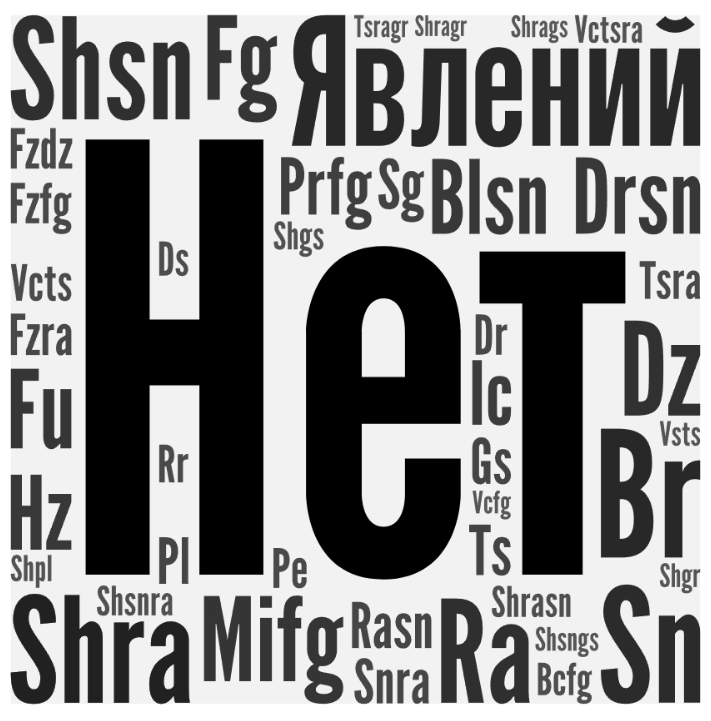

* Видим, что чаще всего явлений не наблюдалось
* Еще из часто встречающихся явлений можно выделить ливневые и обложные осадки в виде снега и дождей, туманы общие, поземные и клочьями, а также дымки. Общая и поземная метель так же часто встречается в наборе данных. 

#### Выводы по предобработке данных 
___
Предобработка данных включала:

* Удаление ненужных строк с нерелевантной информацией (теги, HTML-код и т.п.)
* Удаление сводок с менее чем 8 блоками (отсутствующие сводки METAR)
* Создание столбцов с датой, направлением и скоростью ветра, видимостью, облачностью, атмосферным давлением температурами воздуха и точки россы и влажностью, а также явлениями погоды. 
* Удаление пропусков и выбросов (например, сводка со скоростью ветра 3 м/с и порывом 60 м/с)

**В результате получен чистый и подготовленный к анализу датафрейм с информацией о погодных условиях.**

* Были рассмотрены общие распределения величин и выявлены меры центральных тенденций, необходимые для дальнейшего анализа и создания модели прогноза погоды. 
___

<a id='analysis'></a>
## Статистический анализ

Рассмотрим годовой и суточный ход метеорологических величин

In [55]:
##### ФЦНКЦИЯ ДЛЯ ПОСТРОЕНИЯ ГОДОВОГО И СУТОЧНОГО ХОДА #########
def plot_parameters(par, units, title,agg, data):
  fig = plt.figure(figsize=(20, 10))
  colors = sns.color_palette('Paired')[0:1]
  plt.rc('font', size=15)
  ax1 = plt.subplot(2, 2, 1)
  avg = data.pivot_table(index=data['date'].dt.month, values=par, aggfunc=agg)
  plt.plot(avg.index, avg[par], marker='o', markersize=7, color='mediumpurple')
  plt.axhline(y=avg[par].mean(), color='black', linestyle='--',label = f'Среднее {round(avg[par].mean(),1)}')
  plt.legend(bbox_to_anchor=( -0.05 , 1 ))
  plt.grid(True)
  plt.title('Годовой ход')
  plt.ylabel(units)
  plt.xlabel('Месяц')

  ax2 = plt.subplot(2, 2, 2, sharey=ax1)
  colors = {
    'winter': 'steelblue',
    'spring': 'darkseagreen',
    'summer': 'tomato',
    'autumn': 'goldenrod'}
  for season in data['season'].unique().tolist():
    color = colors.get(season)
    avg = data.query('season == @season').pivot_table(index=data['date'].dt.hour, values=par, aggfunc='mean')
    plt.plot(avg.index, avg[par],
              marker='o',
              markersize=5,
              color=color,
              label=season)
    plt.grid(True)
    plt.title('Суточный ход')
    plt.ylabel(units)
    plt.xlabel('Час')
    plt.legend(bbox_to_anchor=( 1.00 , 1 ))
    plt.text(-0.3, 1.2, title, fontsize=20,transform=ax2.transAxes)



In [56]:
##### ФЦНКЦИЯ ДЛЯ ПОСТРОЕНИЯ БОКСПЛОТОВ ПО СЕЗОНАМ#########
def boxplot_seson(par, units, title,data):
    plt.figure(figsize=(10, 10))
    colors = ['#78C850', '#6890F0','#F8D030','#F08030' ]
    boxplot = sns.boxplot(x=par, y='season',data =data,  palette=colors)
    boxplot.axes.set_title(title, fontsize=16)
    boxplot.set_xlabel(units, fontsize=14)
    boxplot.set_ylabel("Сезон", fontsize=14,rotation = 90)
    plt.show()

### Скорость ветра

Рассмотрим годовой и суточный ход скорости ветра.

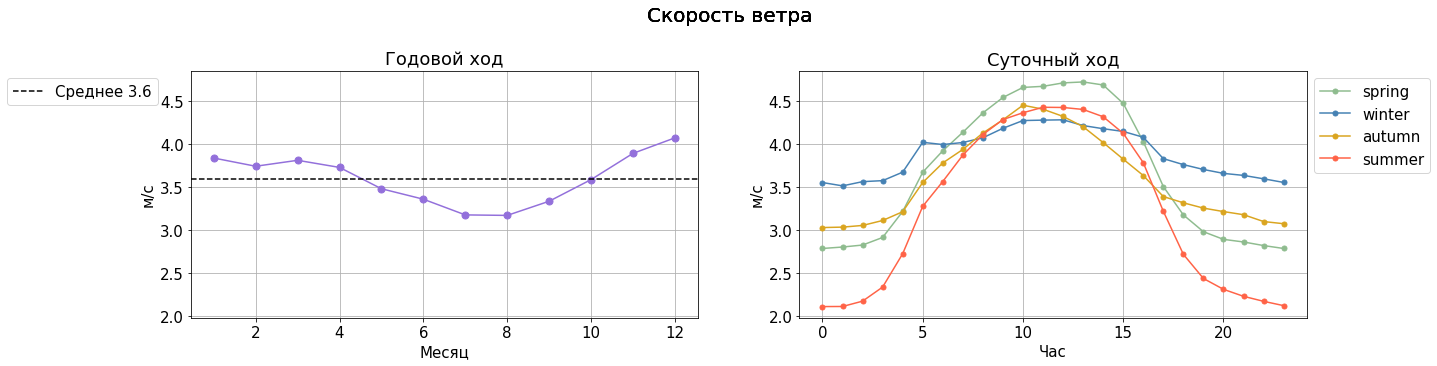

In [57]:
plot_parameters('speed','м/с', 'Скорость ветра','mean',meteo_new)

* Видим, что наибольшие скорости наблюдаются в декабре более 4 м/с, далее с января по август снижается до менее чем 3,25 м/с.
* В суточном ходе наибольшая изменчивость скоростей ветра наблюдается весной и летом максимумы от 10 до 12 часов дня. Весной средняя скорость ветра выше и изменяется от 2,5 в ночное и вечернее время до 4,6 м/с днем.
* В другие времена года максимумы так же наблюдаются в дневные часы. В ночные часы скорости ветра в среднем больше, чем весной и летом. Амплитуды  - от 3,5 до 4,5 м/с



Рассмотрим меру размаха значений скоростей ветра.

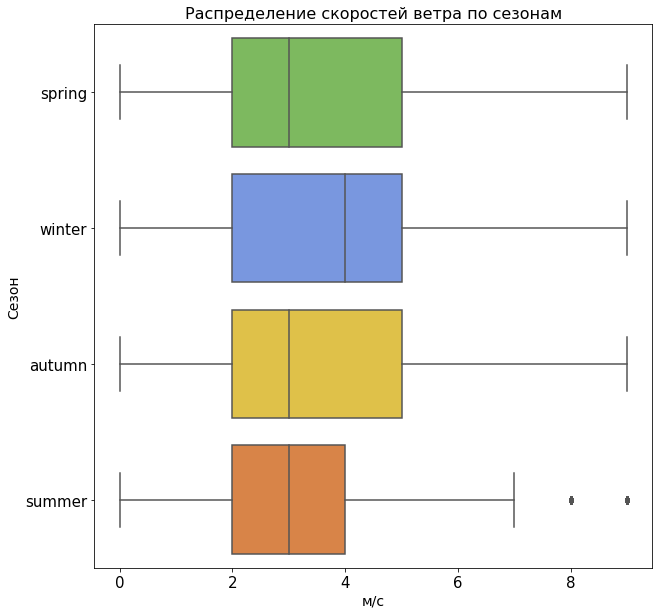

In [58]:
boxplot_seson('speed', "м/с", "Распределение скоростей ветра по сезонам",meteo_new)

* Наблюдаем два выброса в летний сезон: значения 8 и 9 м/с
* Для других сезонов, эти значения скоростей ветра выбросами не являются и входят с основное распределение.
* Медианные значения скорости ветра для зимы наибольшее - 4 м/с
* Для других сезонов медианная скорость ветра 3 м/с


### Направление ветра

Построим розу ветров, отображающую преобладающее направление ветра для всех сводок и в разбивке по сезонам года. Значения на диаграмме отражают процент наблюдения ветров определенных направлений. 

C:\Users\scheo\AppData\Local\Temp/ipykernel_12696/1339771370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dir_range'] = pd.cut(df['direction'], [0, 45, 90, 135,180,225,270,315,360], labels=['ССВ','BСB','ВЮВ','ЮЮВ','ЮЮЗ','ЗЮЗ','ЗСЗ','ССЗ'])


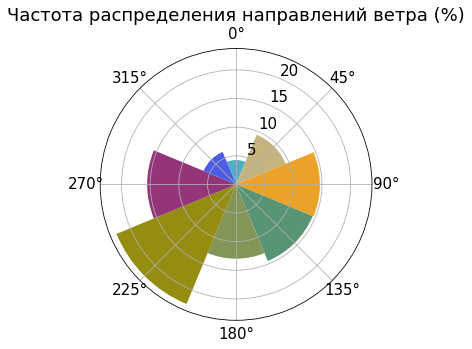

In [59]:
df = meteo_new[['month','direction','speed']]
df['dir_range'] = pd.cut(df['direction'], [0, 45, 90, 135,180,225,270,315,360], labels=['ССВ','BСB','ВЮВ','ЮЮВ','ЮЮЗ','ЗЮЗ','ЗСЗ','ССЗ'])
df = df.pivot_table(index = 'dir_range',values = 'direction',aggfunc = 'count').reset_index()
df['direction'] = df['direction']*100 /sum(df['direction'])

N = 8
theta = np.arange(0., 2 * np.pi, 2 * np.pi / N)

# Данные
radii = np.array(df['direction'].tolist())

# Диаграмма
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection='polar'))
ax.set_theta_offset(np.pi / 2)  # Вершина на севере
ax.set_theta_direction(-1)  # Поворот против часовой стрелки
colors = np.array(['#4bb2c5','#c5b47f','#EAA228','#579575','#839557','#958c12','#953579','#4b5de4'])
# Построение столбчатой диаграммы
bars = ax.bar(theta, radii, width=(2 * np.pi / N), bottom=0.0, color=colors)
plt.title('Частота распределения направлений ветра (%)')
plt.show()

* Видим, что в более чем 20% сводок ветер юго-западных направлений (225°)
* Наиболее редок северный и северо-западный ветер - около 5% всех наблюдений. 

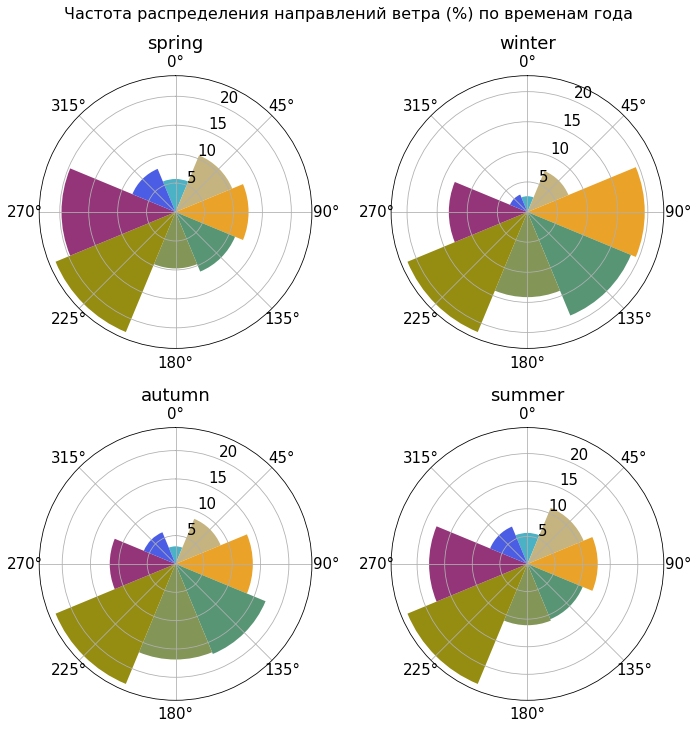

In [60]:
def dir_prosent(data):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10), subplot_kw=dict(projection='polar'))
    axs = axs.ravel()  # Преобразуем массив осей в одномерный список

    for s, ax in enumerate(axs):
        seas = meteo_new['season'].unique().tolist()[s]
        df = meteo_new.query('season == @seas')[['month','direction','speed']]
        df['dir_range'] = pd.cut(df['direction'], [0, 45, 90, 135,180,225,270,315,360], labels=['ССВ','BСB','ВЮВ','ЮЮВ','ЮЮЗ','ЗЮЗ','ЗСЗ','ССЗ'])
        df = df.pivot_table(index = 'dir_range',values = 'direction',aggfunc = 'count').reset_index()
        df['direction'] = df['direction']*100 /sum(df['direction'])
        N = 8
        theta = np.arange(0., 2 * np.pi, 2 * np.pi / N)

        # Данные
        radii = np.array(df['direction'].tolist())
        ax.set_theta_offset(np.pi / 2)  # Вершина на севере
        ax.set_theta_direction(-1)  # Поворот против часовой стрелки
        colors = np.array(['#4bb2c5','#c5b47f','#EAA228','#579575','#839557','#958c12','#953579','#4b5de4'])

        # Построение столбчатой диаграммы
        bars = ax.bar(theta, radii, width=(2 * np.pi / N), bottom=0.0, color=colors)
        ax.set_title(seas)

    # plt.text(0, 0, , fontsize=15)

    fig. tight_layout ()
    plt.text(-1.2, 2.5, 'Частота распределения направлений ветра (%) по временам года', fontsize=16,transform=ax.transAxes)
    plt.show()

dir_prosent(meteo_new)

* Во все сезоны года юго-западный ветер преобладает
* Весной и летом чаще наблюдаются западные ветра (270°), что связано с бризовым эффектом характерным для этого сезона. 
* Зимой чаще наблюдаются ветра восточных и юго-восточных направлений
* Осенью также в более 15% сводок наблюдались южный и юго-восточный ветра.

### Температура

Рассмотрим годовой и суточный ход температуры. 

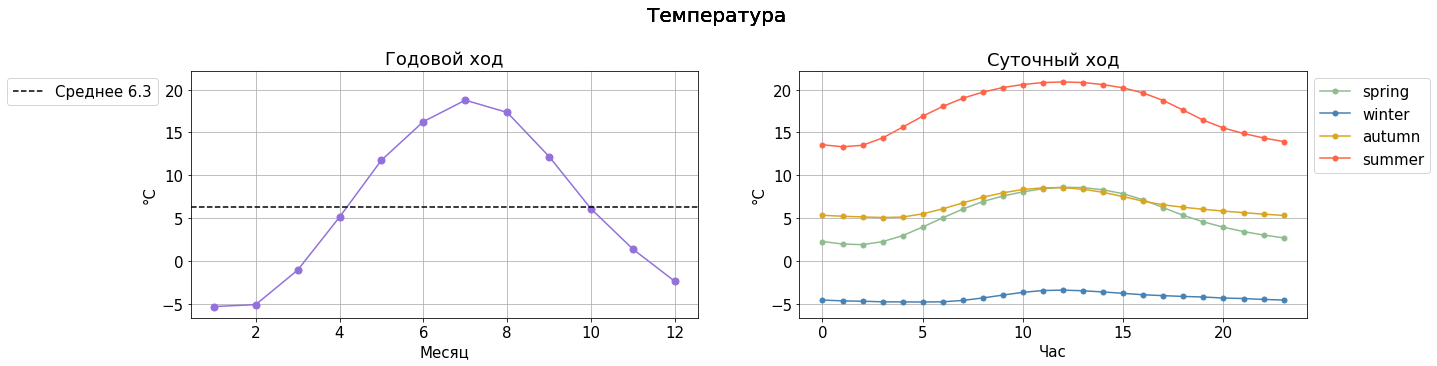

In [61]:
plot_parameters('temperature','°C', 'Температура','mean',meteo_new)

* Средние температуры летом более 15 градусов, зимой от -5 до +3 градусов
* Весной и осенью как среднемесячные температуры, так и в суточном ходе температуры сильно не отличаются: от +2 до +9
* В целом температура имеет правильный годовой и суточный ход с максимумами в летние месяцы и в дневные часы.
* Суточный ход в зимние месяцы не сильно выражен.

Посмотрим размах значений температуры по сезонам года.

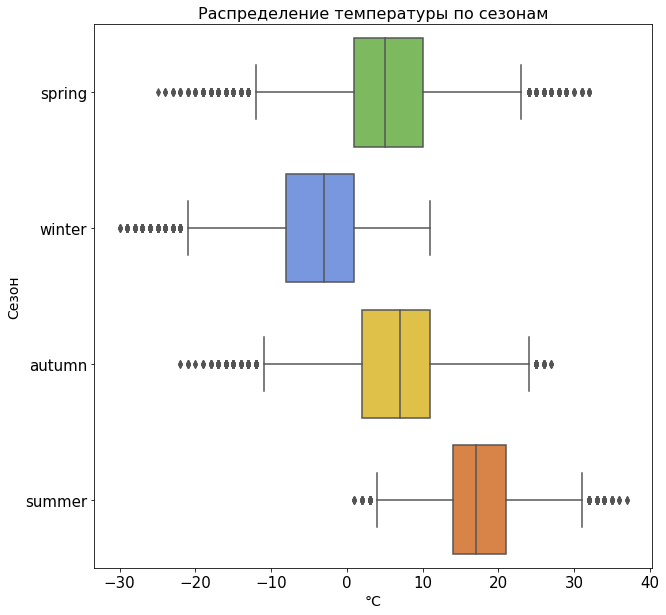

In [62]:
boxplot_seson('temperature','°C',  "Распределение температуры по сезонам",meteo_new)

* Для каждого из сезонов наблюдаются выбросы. Такие, как аномально низкие и высокие температуры.
* В среднем размах значений температур по сезонам одинаков  от 25 до 35 градусов. 

### Влажность

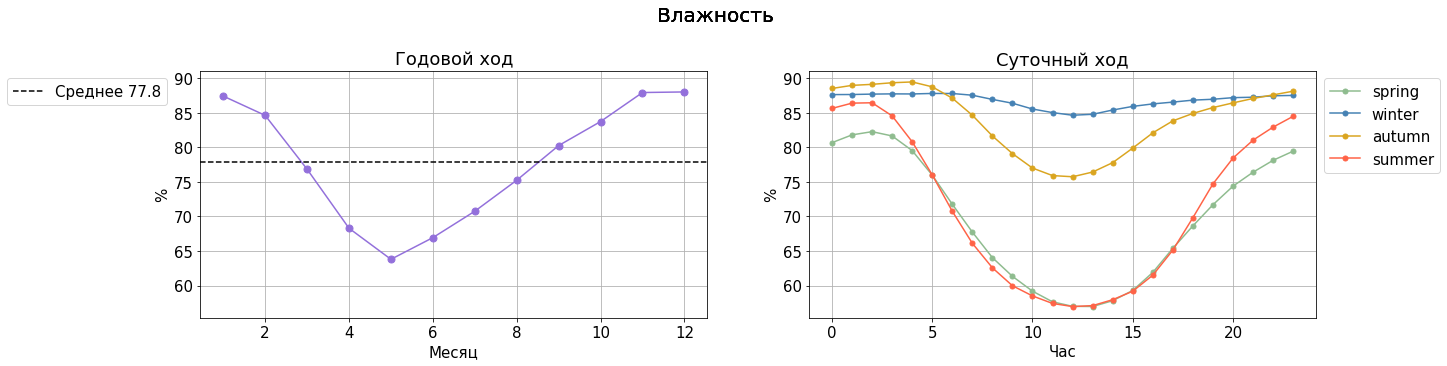

In [63]:
plot_parameters('humidity','%', 'Влажность','mean',meteo_new)

* Относительная влажность наибольшая в зимние месяцы, и наименьшая летом. 
* Суточный ход влажности наиболее сильно выражен летом и весной - в дневные часы наблюдается минимум, к вечеру влажность увеличивается в среднем по 85% и более летом. 
* Суточный ход влажности зимой менее выражен, влажность около 85-87% 

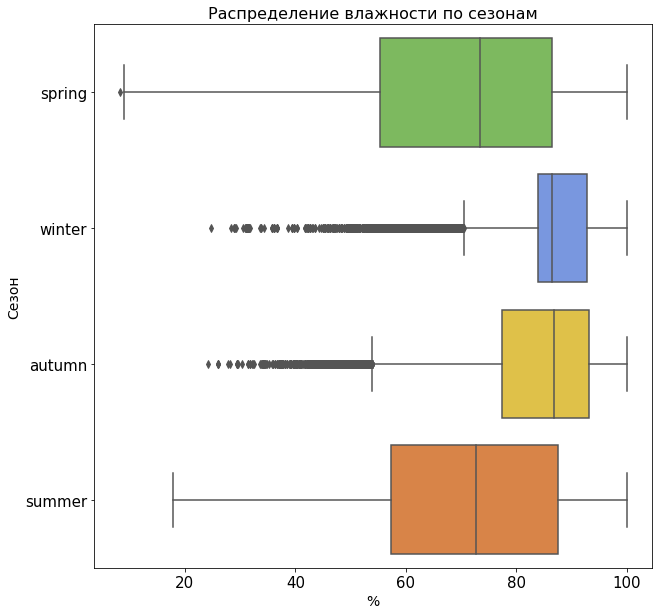

In [64]:
boxplot_seson('humidity','%',  "Распределение влажности по сезонам",meteo_new)

* Много выбросов наблюдается зимой и осенью, что связано с наибольшим количеством осадков в эти сезоны
* Также медианные значения влажности зимой и осенью одинаковы - около 84%
* Летом и весной медиана влажности меньше - 77%

### Видимость

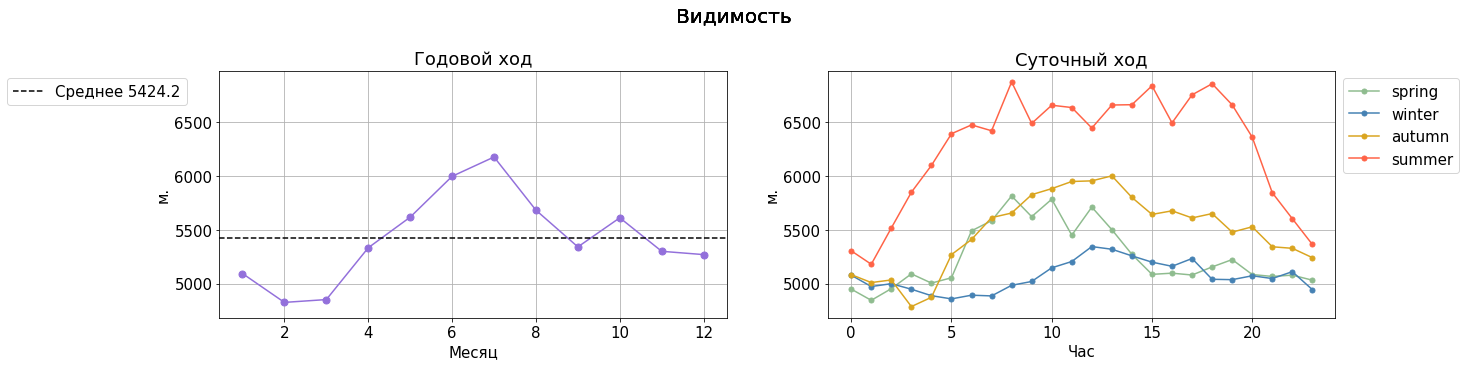

In [65]:
plot_parameters('visibility','м.', 'Видимость','mean',meteo_new)

* Наиболее низкая средняя видимость наблюдается в январе, феврале и марте. За счет наибольшего ухудшения видимости в снегу и весенних туманах.
* Наибольшая видимость наблюдается в июле.
* В суточном ходе видно, что наибольшая видимость в дневные часы, а понижение наблюдается в ночные и утренние часы.

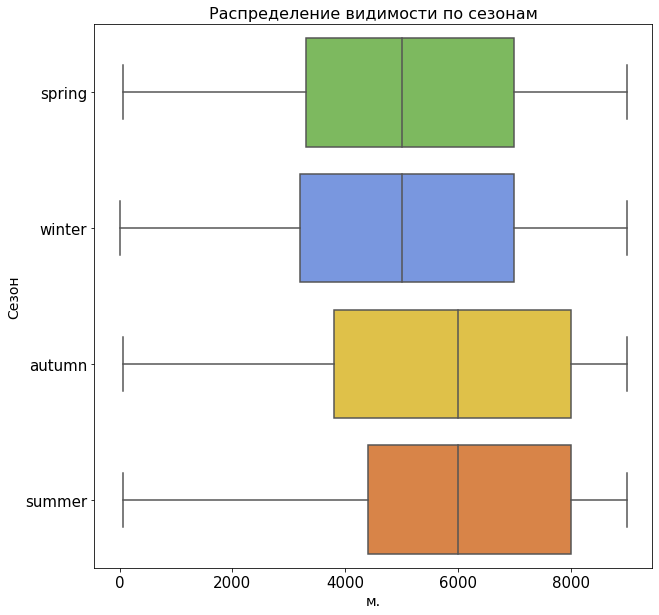

In [66]:
boxplot_seson('visibility','м.', 'Распределение видимости по сезонам',meteo_new)


* Выбросов в данных не обнаружено и разброс значений видимости по сезонам практически идентичен, весной и зимой медианное значение чуть хуже - 5000м против 6000м для осени и лета.

### Высота облачности

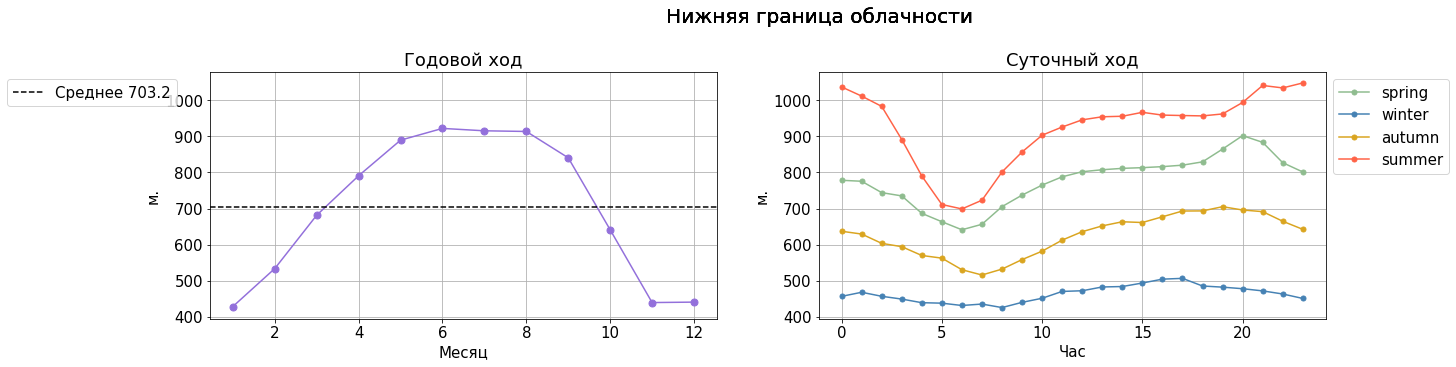

In [67]:
plot_parameters('cloud_base','м.', 'Нижняя граница облачности','mean',meteo_new)

* Наиболее высокая облачность наблюдается с мая по август, самая низкая в зимние месяцы.
* Суточный ход высоты нижней границы облачности зимой выражен не сильно, в остальные сезоны минимум наблюдается в 6-8 часов единого.

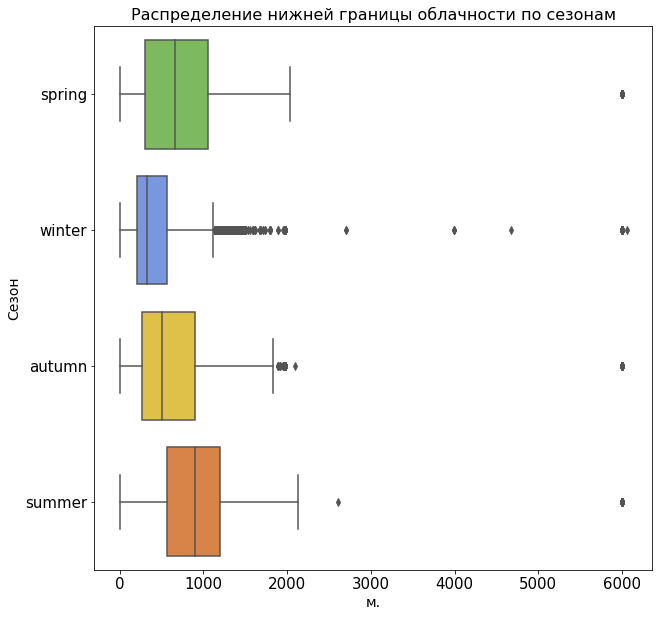

In [68]:
boxplot_seson('cloud_base','м.', 'Распределение нижней границы облачности по сезонам',meteo_new)


* Наибольшее количество выбросов наблюдается в зимний период и медианная видимости для зимы менее 500м.
* В остальные сезоны медиана также менее 1000м 

### Давление

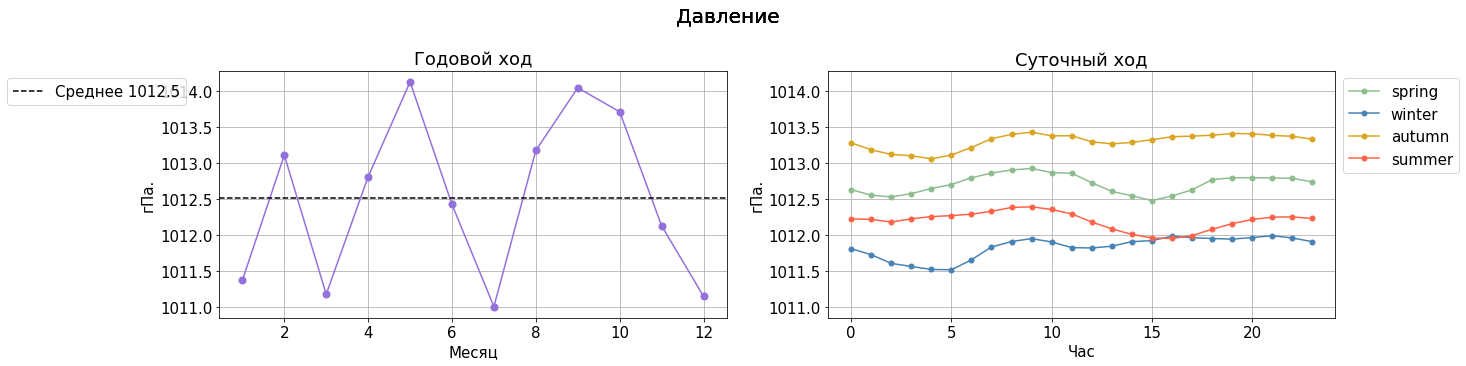

In [69]:
plot_parameters('pressure','гПа.', 'Давление','mean',meteo_new)

* В годовом ходе минимумы давления наблюдаются в марте, июле, декабре и январе
* Наибольшее среднее значение давления в мае - более 1014 гПа

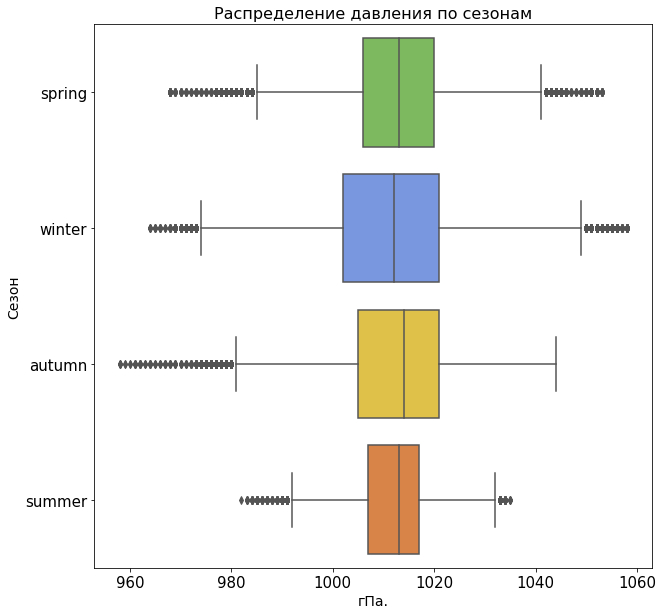

In [70]:
boxplot_seson('pressure','гПа.', 'Распределение давления по сезонам',meteo_new)

* Медианное значение давления в разные сезоны года в целом не отличается - около 1018,1019 гПа
* Наименьший разброс значений наблюдается летом.

### Выводы по статистическому анализу
____
В целом, анализ данных показал, что:
* Скорость ветра достигает максимума в декабре и снижается в течение года, увеличиваясь весной и летом.
* Юго-западные ветры преобладают в течение всего года, хотя летом чаще наблюдаются западные ветры.
* Средняя температура колеблется от -5 до +15 градусов по Цельсию, при резких колебаниях в течение дня и года.
* Относительная влажность выше всего зимой и ниже всего летом, а в течение дня достигает минимума днем и максимума ближе к вечеру.
* Наихудшая видимость наблюдается в зимние месяцы, а наилучшая - летом.
* Облачность наиболее выражена с мая по август, а наименее - зимой.
* Давление имеет годовой цикл с минимумами в марте, июле, декабре и январе и максимумом в мае.
____

<a id='part_1'></a>
## Исследование распределения погодных явлений

Посчитаем количество дней, в которые наблюдались различные явления. Посмотрим распределение количества дней с явлениями по месяцам, времени суток, а также распределение интенсивности явлений.

In [71]:
def weather_distribution_bar(phen,title,color,delit = ['delit']):
        ############# Сочетания явлений
    pie_data = meteo_new.pivot_table(index=meteo_new[meteo_new['phenomena'].str.contains(phen) ]['phenomena'], values='metar', aggfunc='count')['metar']
    for d in delit:
        pie_data = pie_data[~pie_data.index.str.contains(d)]
        
    percent = pie_data*100/pie_data.sum()


    pie_data['other'] = pie_data[pie_data < (pie_data.sum() * 0.01)].sum()
    pie_data = pie_data[pie_data >= (pie_data.sum() * 0.01)]
    fig = plt.figure(figsize=(8, 15))
    colors = sns.color_palette('Paired')[0:16]
    plt.rc('font', size= 15 )
    explode = pie_data/pie_data.sum()
    explode = list(map(lambda x: 0.5 if x<0.03 else 0,explode))

    plt.pie(pie_data, autopct='%1.1f%%',
            colors=colors,explode=explode)
    plt.title(title, loc='left')
    plt.legend(pie_data.index, bbox_to_anchor=(1.50, 1))
    plt.show()

    
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))

######### Количество дней в которые наблюдались явления по месяцам #########
    df = meteo_new[meteo_new['phenomena'].str.contains(phen)]
    for d in delit:
        df = df[~df['phenomena'].str.contains(d)]  
    df = df.pivot_table(index=['month'], values='day', aggfunc='nunique').reset_index()
    ax = axes[0]  # Выбрать поддиаграмму для текущего графика
    sns.barplot(x="month", y="day", data=df, ax=ax, color=color)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  # Установить заголовок графика
    ax.set_title('Количество дней\nв которые наблюдались явления по месяцам', fontsize=10)

######### Распределение дней с явлением по сезонам #########
    df = meteo_new[meteo_new['phenomena'].str.contains(phen)]
    for d in delit:
        df = df[~df['phenomena'].str.contains(d)]  
    df = df.pivot_table(index=['season', 'time_of_day'], values='day', aggfunc='nunique').reset_index()
    
    ax = axes[1]  # Выбрать поддиаграмму для текущего графика
    sns.barplot(x="season", y="day", hue='time_of_day', palette='hls', data=df, ax=ax,color=color)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    legend = ax.legend(fontsize=10)
    legend.set_bbox_to_anchor(( 1.00 , 1 ))
    ax.set_title('Распределение дней с явлением по сезонам\nв разное время суток', fontsize=10)


######### Распределение интерсивности явления по сезонам#########
    if phen != 'FG' and phen != 'BR':
        idnex_two = 'intensity'
    else:
        if phen == 'FG':
            idnex_two = 'intensity_fg'
        elif phen == 'BR':
            idnex_two = 'intensity_br'


    df = meteo_new[meteo_new['phenomena'].str.contains(phen)]
    for d in delit:
        df = df[~df['phenomena'].str.contains(d)]
    df = df.pivot_table(index = ['season',idnex_two],values = 'day',aggfunc = 'nunique').reset_index()
    
    ax = axes[2]  # Выбрать поддиаграмму для текущего графика
    sns.barplot(x="season", y="day",hue = idnex_two ,palette='hls',data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    legend = ax.legend(fontsize=10)
    legend.set_bbox_to_anchor(( 1.00 , 1 ))
    plt.title('Распределение дней с явлением разной интенсивности\nпо сезонам',fontsize=10)
    # Показать все графики
    fig.tight_layout()
#     fig.suptitle(title, fontsize=20,y=1.05)
    plt.show()
    


    return 


#### Дождь

Рассмотрим какие сочетания явлений встречались вместе с дождем и распределение дней с дождем по месяцам, времени суток и интенсивности. Исключим из анализа переохлажденные осадки и снег с дождем. Дождь со снегом оставим. 

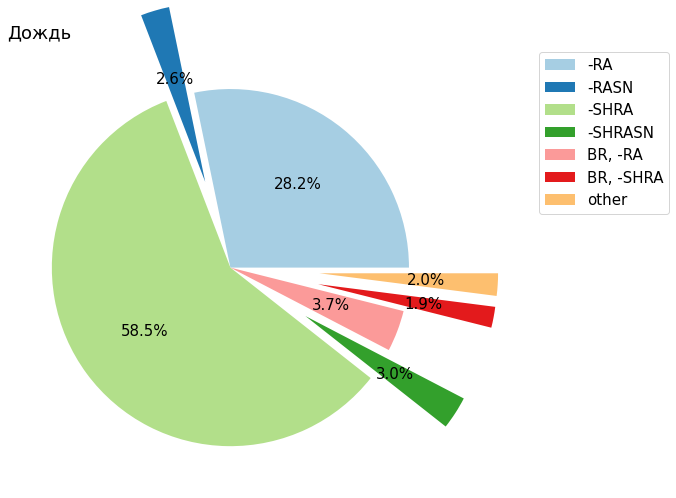

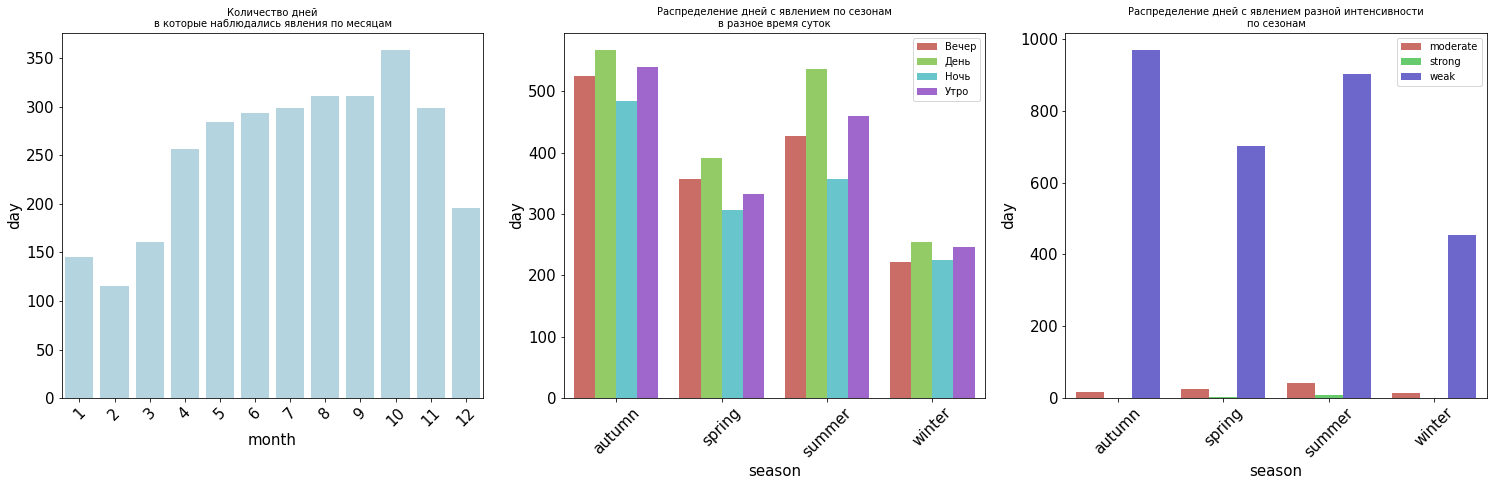

In [72]:
weather_distribution_bar('RA','Дождь','lightblue', delit = ['SNRA', 'FZ'])

* Видим, что в более чем половине случаев дождя наблюдался слабый ливневый дождь. 
* На втором месте по встречаемости слабый обложной дождь
* Все остальные сочетания наблюдались намного реже.

* Дождь на аэродроме наблюдался во все месяца года. Дольше всего дней с дождем отмечено в октябре. В  более 350 дней за 19 лет наблюдений. 
* Также много дней с дождем с апреля по октябрь, меньше всего дождь наблюдался в феврале. 
* Весной дождь наблюдался чаще всего вечером и днем. В остальные сезоны года - днем и утром. 
* По интенсивности преобладают слабые дожди во все времена года. Умеренные и сильные осадки также в течение года имеют похожее распределение

#### Снег

Исключим переохлажденные осадки и дождь со снегом. 

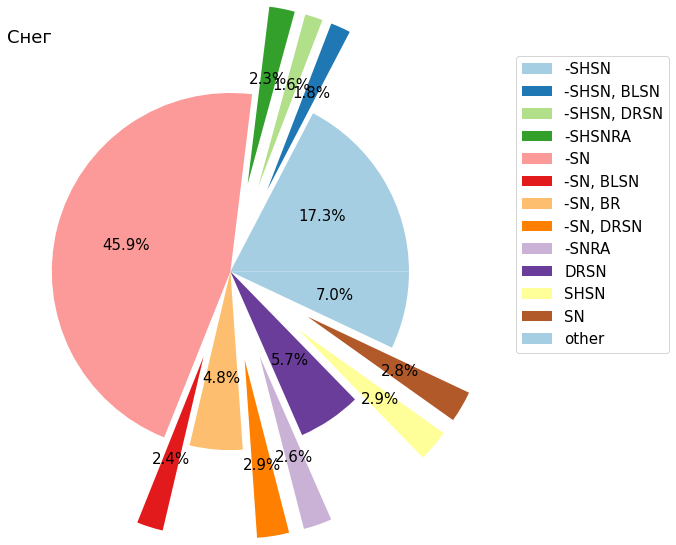

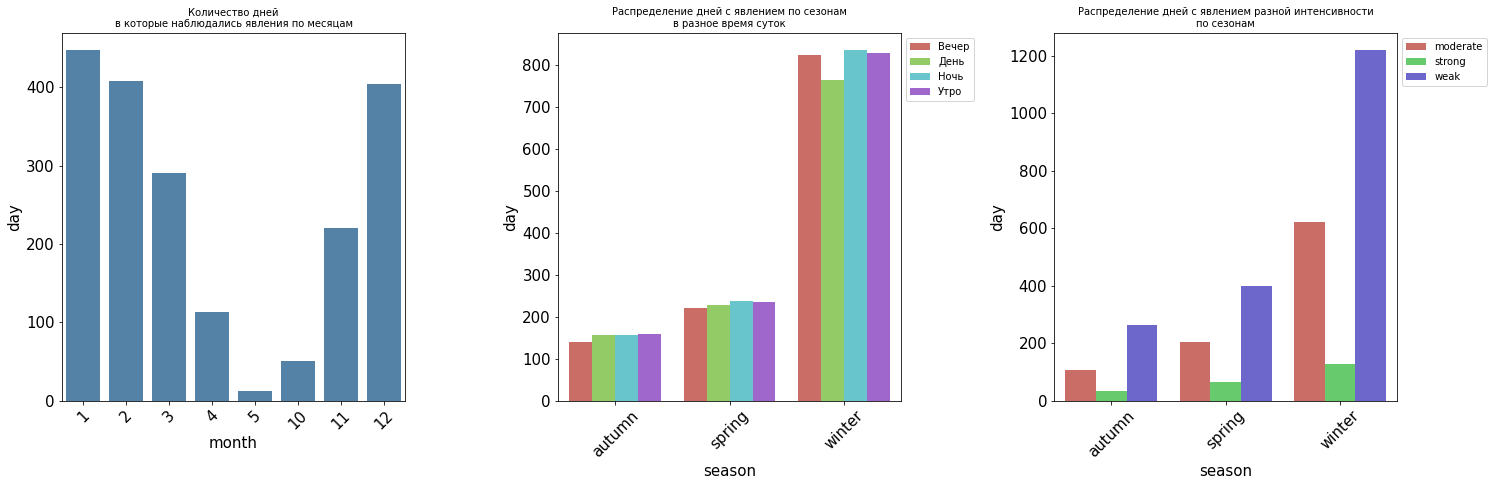

In [73]:
weather_distribution_bar('SN','Снег','steelblue',delit = ['FZRA', 'RASN'])

* Вариантов сочетаний явлений со снегом очень много. Чаще всего встречается слабый обложной снег. На втором месте слабый ливневый снег. Остальных сочетаний менее 6%
* Очевидно, что больше всего дней, когда наблюдался снег в зимние месяцы. За 19 лет измерений менее 25 дней снег наблюдался в мае и более 100 дней в апреле. 
* Осенью и весной снег наблюдался в различное время суток практически одинаково, чуть чаще утром. Зимой реже всего снег наблюдался днем. 
* По интенсивности чаще всего наблюдаемый снег слабой интенсивности, однако приличное количество дней наблюдался умеренный снег. Это связано с тем, что снег сильнее ухудшает видимость нежели дождь, поэтому в сводках чаще можно встретить SN и +SN, чем RA и +RA 

#### Туманы и дымки

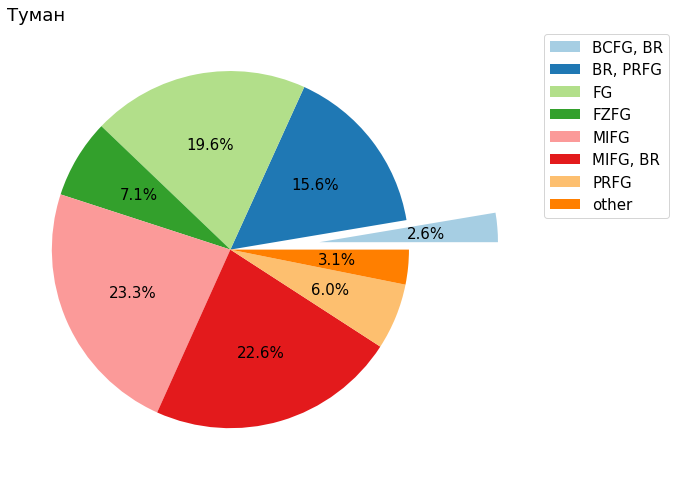

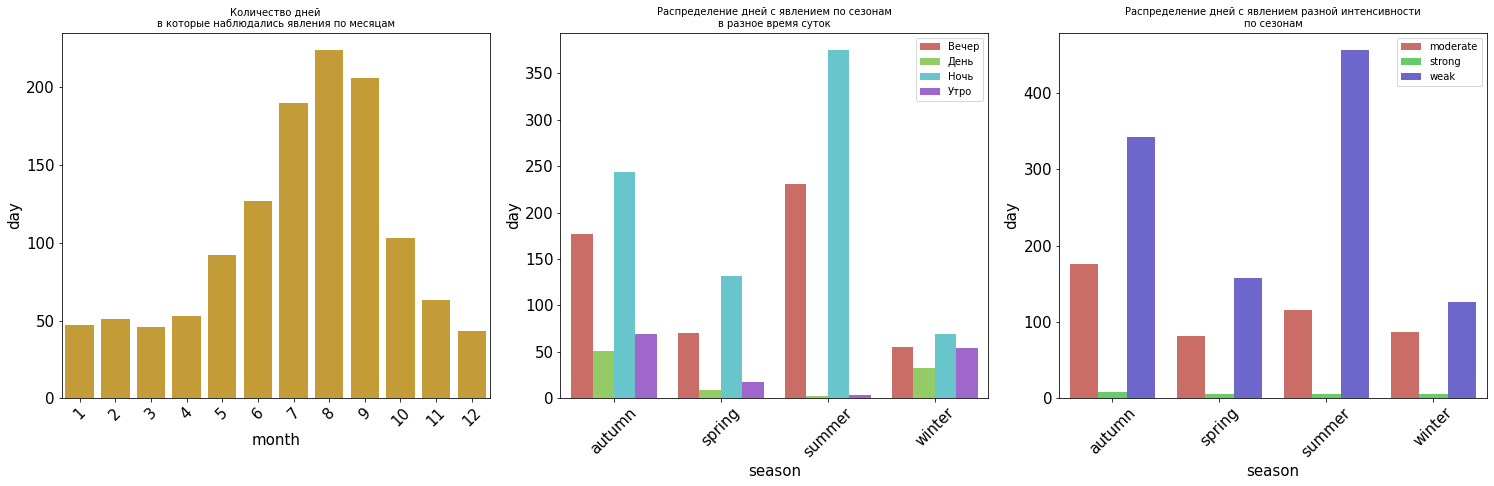

In [74]:
weather_distribution_bar('FG','Туман','goldenrod')

* Туманы могут сочетаться с большим количеством явлений в равных долях. С небольшим отрывом "лидирует" поземный туман - 23,3%
* Наибольшее количество дней с туманом наблюдается с июля по сентябрь. Туманы наблюдаются в течении всего года. 
* Чаще всего туманы наблюдаются в ночное время суток, чуть реже вечером. Зимой разброс в количестве дней с туманом в разное время суток менее выражен, чем в другие времена года.
* Интенсивность чаще всего слабая, т.е. для туманов видимость 500-1000 м. Сильные туманы наблюдаются наиболее редко. 

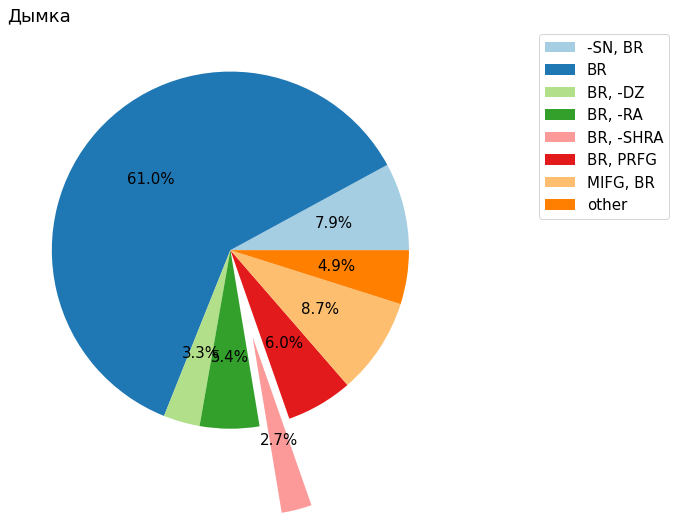

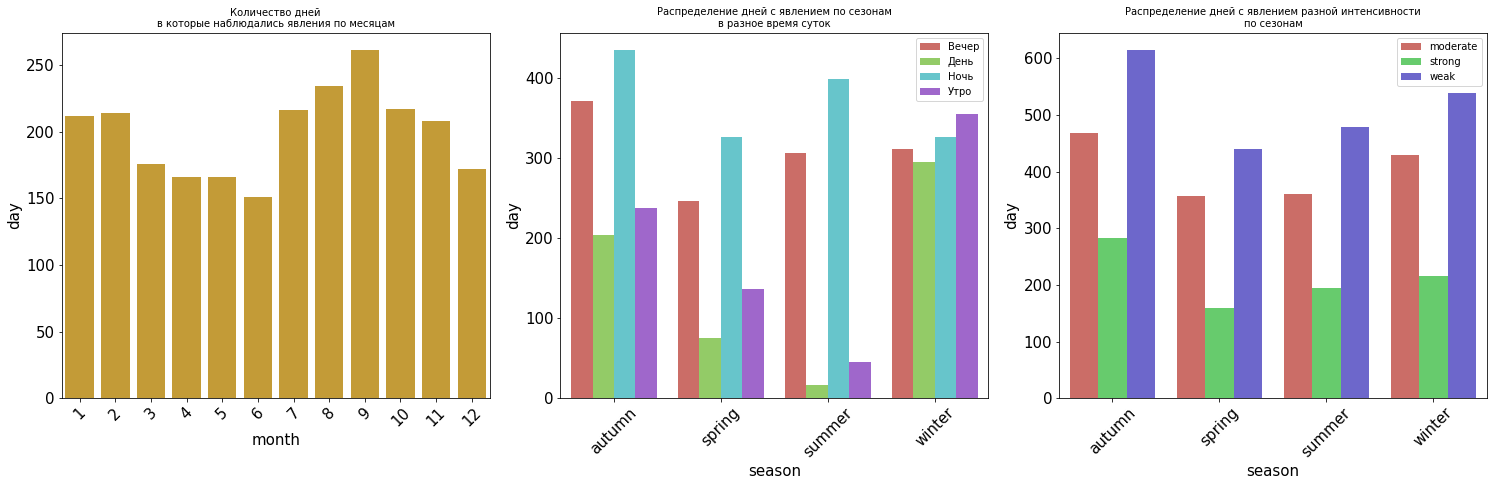

In [75]:
weather_distribution_bar('BR','Дымка','goldenrod')

* В более чем 60% случаев наблюдается просто дымка. 
* Распределение дней с дымкой имеет 2 максимума в январе и феврале и в сентябре. Дымки наблюдаются в течении всего года. 
* Чаще всего дымки наблюдаются в ночное время суток, чуть реже вечером, зимой дымки чаще всего наблюдаются в утренние часы.
* Интенсивность чаще всего слабая, т.е. для дымок 4-10 км. Так же не редко наблюдаются умеренные и сильные дымки. 

PS интенсивность дымок и туманов в данном случае определяется по преобладающей видимости наблюдаемой в данный срок

#### Грозы

Стоит отметить, что касаемо гроз интенсивность указывается для явления, с которым наблюдается гроза - т.е. интенсивность будет указана для наблюдаемого дождя. Также в сводке может быть указана гроза в окрестности аэродрома VCTS в этом случае интенсивность для данных сроков не рассчитывается.

Рассмотрим сочетания явлений, которые встречались при грозе, а также распределения количества дней с грозой. 

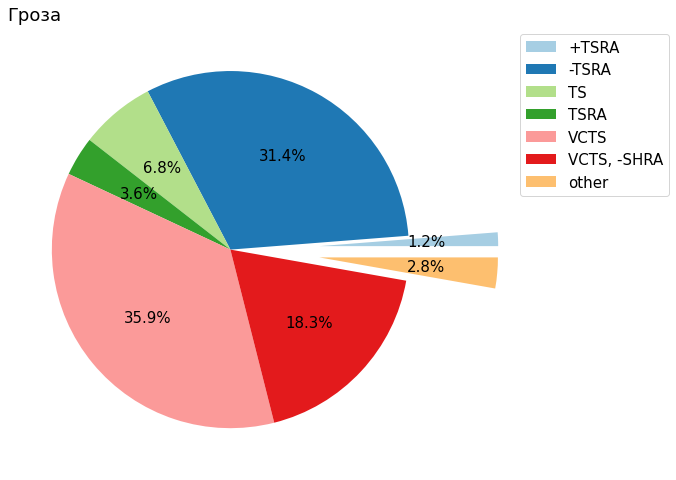

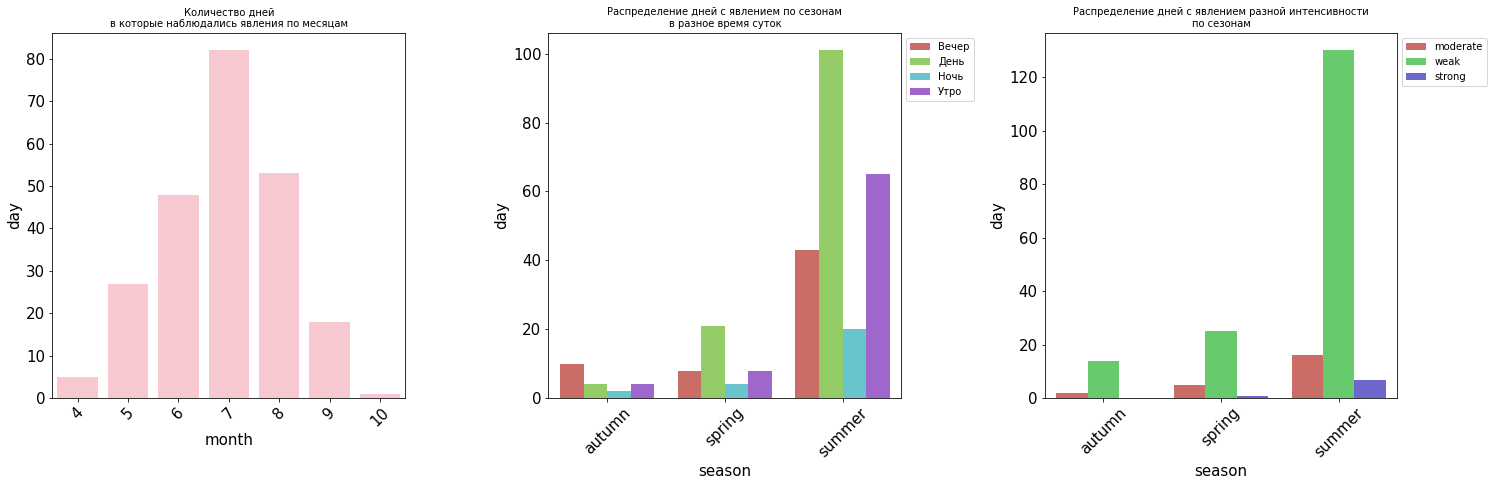

In [76]:
weather_distribution_bar('TS','Гроза','pink')

* Чаще всего наблюдалась гроза в окрестности - 35,9% из всех наблюдений грозы. 
* Редко встречался сильный дождь с грозой и такие сочетания  как слабый дождь с градом, дымка и гроза, умеренный ливневый дождь и другие.
* Наибольшее количество дней, когда наблюдалась гроза в июле - около 80 дней. С ноября по март грозы не наблюдаются. 
* Больше всего гроз наблюдается днем и чуть менее утром, реже всего можно увидеть ночные грозы. 
* Грозы как правило наблюдаются при слабом дожде.

#### Переохлажденные осадки

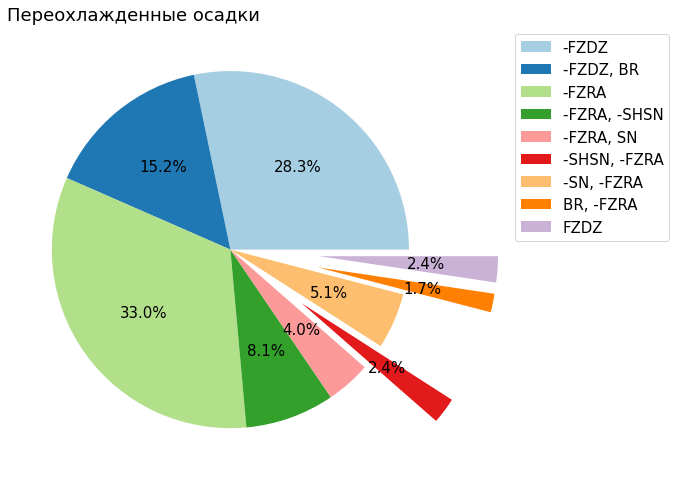

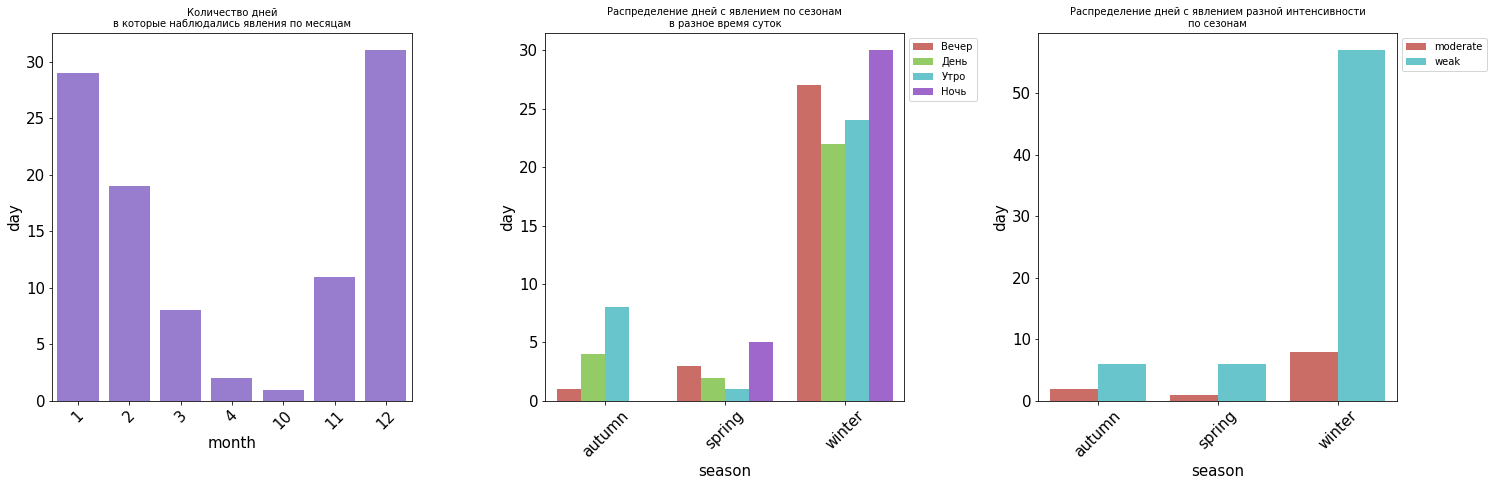

In [77]:
weather_distribution_bar('FZ','Переохлажденные осадки','mediumpurple',delit = ['FG'])

* Чаще всего встречается слабый переохлажденный дождь, чуть реже (но ненамного) слабая переохлажденная морось.
* В течение года переохлажденные осадки наблюдаются с октября по апрель. Наибольшее количество дней в декабре и январе. 
* Осенью не было отмечено дней с переохлажденными осадками в ночное время суток, а максимум - утром. 
* Зимой и весной максимум дней с осадками в ночные часы, чуть реже - вечером. 
* В преобладающем большинстве случаев осадки слабой интенсивности. Сильных осадков не наблюдалось вовсе. 

#### Выводы по распределениям погодных явлений
___
* Большинство случаев дождя относится к слабым ливневым или слабым обложным дождям.
* Дождь наблюдается во все месяцы года, чаще всего в октябре и наименее часто в феврале.
* По интенсивности преобладают слабые дожди во все времена года.
* Снег чаще всего наблюдается в зимние месяцы, слабой или умеренной интенсивности.
* Туманы чаще всего наблюдаются в ночное время суток с июля по сентябрь, обычно слабой интенсивности.
* Дымку можно наблюдать в течение всего года, чаще всего в январе, феврале и сентябре, в основном слабой или умеренной интенсивности.
* Грозы чаще всего наблюдаются в окрестностях аэродрома и обычно сопровождаются слабым дождем.
* Грозы чаще всего происходят в июле и днем.
* Переохлажденные осадки чаще всего наблюдаются зимой и весной, в основном слабой интенсивности.
____

<a id='part_2'></a>
## Оценка взаимосвязей между метеорологическими параметрами

###  Корреляционный анализ
Вычислим коэффициенты корреляции между различными парами количественных переменных.



<AxesSubplot:>

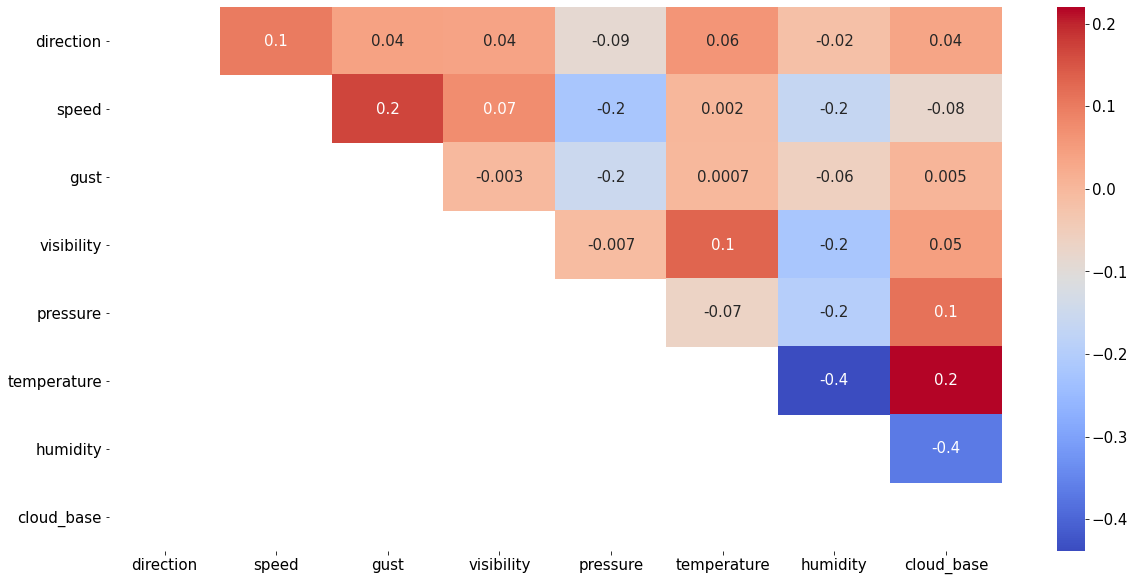

In [78]:
correl = meteo_new[['direction','speed',	'gust',	'visibility',	'pressure',	'temperature',	'humidity','cloud_base']].corr()
mask = np.tril(correl)
plt.figure(figsize=(20, 10))
sns.heatmap(correl,annot = True,cmap= 'coolwarm',mask=mask,fmt='.1g')

* Наибольшая отрицательная корреляция (40%) наблюдается между `влажностью и нижней границей облачности`. Чем больше влажность, тем облачность ниже. 
* Положительная отрицательная корреляция в 20% наблюдается между параметрами: 
    * `Скоростью ветра и давлением, а также скоростью ветра и влажностью`
    * `Порывами ветра и давлением`
    * `Видимостью и влажностью` 
    * `Температурой и нижней границей облачности`
* Корреляция в 10% между 
    * `направлением ветра и скоростью`
    * `видимостью и температурой` 
    * `давлением и нижней границей облаков`
    
PS Большие коэффициенты корреляции наблюдаются у  влажности и температуры, а также между скоростью ветра и порывом, но это примем за автокорреляцию


Полученные зависимости пригодятся нам для дальнейшей разработки прогностической модели. 

<a id='theend'></a>
## Общий вывод
___
Проведенный анализ данных показал, что погодные условия на исследуемом аэродроме характеризуются следующими основными закономерностями:

- Преобладают слабые или умеренные осадки (дождь или снег), особенно в осенне-зимний период.
- Ветер чаще всего дует с юго-запада, его скорость имеет сезонные колебания.
- Температура воздуха колеблется в широком диапазоне в течение года, с экстремальными значениями в зимние и летние месяцы.
- Влажность и облачность также имеют сезонные колебания, с более высокой влажностью и облачностью в холодные месяцы и более низкой влажностью и облачностью в теплые месяцы.
- Видимость обычно лучше летом и хуже зимой.
- Давление воздуха имеет годовой цикл с минимумами в марте, июле, декабре и январе и максимумом в мае.

**Наиболее ценная информация для построения прогностической модели**:

- Средние значения и стандартные отклонения для различных метеорологических параметров (скорость ветра, направление ветра, температура, влажность и т. д.).
- Коэффициенты корреляции между различными метеорологическими параметрами.
- Информация о распределении погодных явлений (дождь, снег, туман и т. д.).
- Сезонные и суточные колебания метеорологических параметров.
___


*PS*
*Направления для дальнейшего рассмотрения:*

*- Влияние высоты облачности на температуру и осадки.*

*- Связь между направлением ветра и скоростью ветра.*

*- Корреляция между видимостью и относительной влажностью.*

*- Учет данных о топографии и близости водоемов для улучшения прогнозирования туманов и дымки.*

### Регрессионный анализ
 </font><font color='Red'><b> In Progress</b>


### Разработка модели прогноза погоды
 </font><font color='Red'><b> In Progress</b>